In [1]:
import os
os.getpid()

17839

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
idx = pd.IndexSlice
import numpy as np
from numpy import log10
import os.path
from pathlib import Path
import re
import lxml.etree as etree
#import xml.etree.ElementTree as ET
import json

import ete3
from ete3 import NCBITaxa
# Note that the NCBITaxa local database can be update with function update_taxonomy_database()
from ete3 import PhyloTree, Tree, TreeStyle, TreeNode, TreeFace, NodeStyle
from ete3.coretype.tree import TreeError

# Use autoreload to keep up-to-date version of custom packages
import sys
sys.path.insert(0, '../src')
%load_ext autoreload
%aimport mwTools
%aimport cterminal
%autoreload 1

from importlib import reload
from cterminal import read_assemblySummary_file
from cterminal import simplify_prefix
from cterminal import select_terminal_positions_in_index
from cterminal import aaTable
from mwTools.paths import p
import mwTools.general
from mwTools.general import piecewise

from matplotlib_options import set_fontsize_paper, set_fontsize_screen

p = p()
print(p.rootPath)
mpnAnnotationPath = p.mpnAnnotationPath
rootPath = p.rootPath
cterminalPath = p.cterminalPath
analysisCtermPath = p.analysisCtermPath
refSeqPath = p.refSeqPath
analysisCtermDataPath = p.analysisCtermDataPath
taxonomyPath = p.taxonomyPath
phylaPath = p.phylaPath
entrezGenePath = p.entrezGenePath
OMAPath = p.OMAPath
eggNOGPath = p.eggNOGPath
NCBI_COG_path = p.NCBI_COG_path
analysisEggnogPath = p.analysisEggnogPath

print(len(aaTable))

/users/lserrano/mweber
20


In [3]:
taxonomyPath

PosixPath('/users/lserrano/mweber/Databases/RefSeq/Release_2016_10/Entrez_taxonomy')

## NCBI Taxonomy database

### Collect species list for each rank node

In [4]:
ncbi = NCBITaxa()

In [29]:
# ncbi.update_taxonomy_database()

Done. Parsing...


Loading node names...
2112706 names loaded.
208748 synonyms loaded.
Loading nodes...
2112706 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/mweber/.etetoolkit/taxa.sqlite ...
 2112000 generating entries... enerating entries... generating entries... 
Uploading to /home/mweber/.etetoolkit/taxa.sqlite


Inserting synonyms:          0 

Inserting synonyms:      205000 

Inserting taxid merges:  50000 

Inserting taxids:       2110000  

In order to get the list of all Phyla, we build the whole tree for the bacteria kingdom, then extract only the nodes with rank phylum and build a set of phyla names.

In [5]:
# Build the whole taxonomy tree (can take a while... 2-3 minutes, <1 GB memory)
bacteriaTree = ncbi.get_descendant_taxa(2, return_tree=True)

In [6]:
print(bacteriaTree.rank)

superkingdom


In [7]:
# Example of the lineage of one bacteria and the list of ranks
# E. coli taxid = 562
for node in ncbi.get_lineage(438753):
    print("rank:", ncbi.get_rank([node]), "rank name:", ncbi.get_taxid_translator([node]))

rank: {1: 'no rank'} rank name: {1: 'root'}
rank: {131567: 'no rank'} rank name: {131567: 'cellular organisms'}
rank: {2: 'superkingdom'} rank name: {2: 'Bacteria'}
rank: {1224: 'phylum'} rank name: {1224: 'Proteobacteria'}
rank: {28211: 'class'} rank name: {28211: 'Alphaproteobacteria'}
rank: {356: 'order'} rank name: {356: 'Rhizobiales'}
rank: {335928: 'family'} rank name: {335928: 'Xanthobacteraceae'}
rank: {6: 'genus'} rank name: {6: 'Azorhizobium'}
rank: {7: 'species'} rank name: {7: 'Azorhizobium caulinodans'}
rank: {438753: 'no rank'} rank name: {438753: 'Azorhizobium caulinodans ORS 571'}


In [14]:
species_name = 'Citrobacter_FDAARGOS_156.GCF_001559235.1'

In [46]:
s = species_name
print(s)
taxa = ncbi.get_name_translator([s])
if len(taxa) == 0:
    m = re.search(r'([a-zA-Z0-9]+?)_([\w\d_]+)\.(.+)$', species_name)
    print(m.groups())
    if m:
        species_name_1 = m.group(1)
        species_name_2 = re.sub(r'_', r' ', m.group(2))
        genome_id = m.group(3)
        s = '{} {}'.format(species_name_1, species_name_2)
        print(s)
        taxa = ncbi.get_name_translator([s])
        if len(taxa) == 0:
            species_name_2a = re.search(r'(.+)\s.+', species_name_2).group(1)
            s = '{} {}'.format(species_name_1, species_name_2a)
            print(s)
            taxa = ncbi.get_name_translator([s])
            if len(taxa) == 0:
                s = '{}'.format(species_name_1)
                print(s)
                taxa = ncbi.get_name_translator([s])
                if len(taxa) == 0:
                    print("ERROR: cannot find taxa of simplified species name:", s)
    else:
        print("ERROR: cannot parse the species name:", species_name)
print("taxa:", taxa)
if len(taxa) > 0:
    taxid = list(taxa.values())[0][0]
    print(taxid)

for node in ncbi.get_lineage(taxid):
    print("rank:", ncbi.get_rank([node]), "rank name:", ncbi.get_taxid_translator([node]))
    
genus = [ncbi.get_taxid_translator([node]) for node in ncbi.get_lineage(taxid)
         if list(ncbi.get_rank([node]).values()) == ['genus']]
genus

Citrobacter_FDAARGOS_156.GCF_001559235.1
('Citrobacter', 'FDAARGOS_156', 'GCF_001559235.1')
Citrobacter FDAARGOS 156
Citrobacter FDAARGOS
Citrobacter
taxa: {'Citrobacter': [544]}
544
rank: {1: 'no rank'} rank name: {1: 'root'}
rank: {131567: 'no rank'} rank name: {131567: 'cellular organisms'}
rank: {2: 'superkingdom'} rank name: {2: 'Bacteria'}
rank: {1224: 'phylum'} rank name: {1224: 'Proteobacteria'}
rank: {1236: 'class'} rank name: {1236: 'Gammaproteobacteria'}
rank: {91347: 'order'} rank name: {91347: 'Enterobacterales'}
rank: {543: 'family'} rank name: {543: 'Enterobacteriaceae'}
rank: {544: 'genus'} rank name: {544: 'Citrobacter'}


[{544: 'Citrobacter'}]

In [42]:
node = ncbi.get_lineage(taxid)[7]
list(ncbi.get_rank([node]).values())

['genus']

In [45]:
[ncbi.get_taxid_translator([node]) for node in ncbi.get_lineage(taxid) if list(ncbi.get_rank([node]).values()) == ['genus']]

[{544: 'Citrobacter'}]

In [10]:
ncbi.get_name_translator(['Citrobacter FDAARGOS'])

{}

In [11]:
ncbi.get_name_translator(['Citrobacter'])

{'Citrobacter': [544]}

## Merge taxonomic groups with RefSeq genomes database

In [7]:
assemblySummaryRepDf = read_assemblySummary_file(str(refSeqPath / 'assembly_summary_refseq.txt'))

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Nb of genomes in RefSeq database: 75064
Nb of genomes in RefSeq database, representative or reference genomes: 6165
Nb of genomes in RefSeq database, after filtering out contigs: 1773


Column 7: "species_taxid" Species taxonomy ID: the NCBI taxonomy identifier for the species from which the genome assembly was derived. The species taxid will differ from the organism taxid (column 6) only when the organism was reported at a sub- species or strain level.

Most of genomes are described at the subspecies level, such that the `species_taxid` is different from the (subspecies) `taxid`.

In [8]:
assemblySummaryRepDf[ assemblySummaryRepDf.apply(lambda row: row['species_taxid'] != row['taxid'], axis=1 ) ].iloc[0,:6]

bioproject                    PRJNA15564
biosample                   SAMEA3138173
wgs_master                           NaN
refseq_category    representative genome
taxid                             347515
species_taxid                       5664
Name: GCF_000002725.2, dtype: object

There are also a few cases where we have several subspecies from the same species, such that these organisms have the same `species_taxid`.

In [9]:
assemblySummaryRepDf[ assemblySummaryRepDf.duplicated('species_taxid', keep=False) ]

,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,version_status,...,release_type,genome_rep,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,compressedGenomeFilename
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000005845.2,PRJNA57779,SAMN02604091,NaN,reference genome,511145,562,Escherichia coli str. K-12 substr. MG1655,strain=K-12 substr. MG1655,NaN,latest,...,Major,Full,2013/09/26,ASM584v2,Univ. Wisconsin,GCA_000005845.2,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000005845.2_ASM584v2_genomic.gbff.gz
GCF_000006905.1,PRJNA57891,SAMN02604005,NaN,reference genome,190650,155892,Caulobacter crescentus CB15,strain=CB15,NaN,latest,...,Major,Full,2002/03/06,ASM690v1,NaN,GCA_000006905.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000006905.1_ASM690v1_genomic.gbff.gz
GCF_000006945.1,PRJNA57799,SAMN02604315,NaN,reference genome,99287,28901,Salmonella enterica subsp. enterica serovar Ty...,strain=LT2; SGSC 1412; ATCC 700720,NaN,latest,...,Major,Full,2001/10/26,ASM694v1,Washington University Genome Sequencing Center,GCA_000006945.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000006945.1_ASM694v1_genomic.gbff.gz
GCF_000007325.1,PRJNA57885,SAMN02603417,NaN,reference genome,190304,851,Fusobacterium nucleatum subsp. nucleatum ATCC ...,strain=ATCC 25586,NaN,latest,...,Major,Full,2002/04/09,ASM732v1,NaN,GCA_000007325.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000007325.1_ASM732v1_genomic.gbff.gz
GCF_000007365.1,PRJNA224116,SAMN02604269,NaN,representative genome,198804,9,Buchnera aphidicola str. Sg (Schizaphis graminum),strain=Sg (Schizaphis graminum),NaN,latest,...,Major,Full,2002/07/02,ASM736v1,NaN,GCA_000007365.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000007365.1_ASM736v1_genomic.gbff.gz
GCF_000007725.1,PRJNA224116,SAMN02604289,NaN,representative genome,224915,9,Buchnera aphidicola str. Bp (Baizongia pistaciae),strain=Bp (Baizongia pistaciae),NaN,latest,...,Major,Full,2003/01/29,ASM772v1,NaN,GCA_000007725.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000007725.1_ASM772v1_genomic.gbff.gz
GCF_000007845.1,PRJNA57909,SAMN02603432,NaN,reference genome,198094,1392,Bacillus anthracis str. Ames,strain=Ames,NaN,latest,...,Major,Full,2003/04/30,ASM784v1,NaN,GCA_000007845.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000007845.1_ASM784v1_genomic.gbff.gz
GCF_000007925.1,PRJNA57995,SAMN02603142,NaN,reference genome,167539,1219,Prochlorococcus marinus subsp. marinus str. CC...,strain=CCMP1375; SS120,NaN,latest,...,Major,Full,2003/07/25,ASM792v1,NaN,GCA_000007925.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000007925.1_ASM792v1_genomic.gbff.gz
GCF_000008165.1,PRJNA58091,SAMN02598266,NaN,reference genome,260799,1392,Bacillus anthracis str. Sterne,strain=Sterne,NaN,latest,...,Major,Full,2004/06/24,ASM816v1,NaN,GCA_000008165.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000008165.1_ASM816v1_genomic.gbff.gz


There is even one pair of genomes that are the same subspecies but from different samples.

In [10]:
assemblySummaryRepDf[ assemblySummaryRepDf.duplicated(['species_taxid','taxid'], keep=False) ]

,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,version_status,...,release_type,genome_rep,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,compressedGenomeFilename
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000219605.1,PRJNA224116,SAMN02603041,NaN,representative genome,316,316,Pseudomonas stutzeri,strain=CGMCC 1.1803,NaN,latest,...,Major,Full,2011/06/29,ASM21960v1,NaN,GCA_000219605.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000219605.1_ASM21960v1_genomic.gbff.gz
GCF_000590475.1,PRJNA224116,SAMN02673421,NaN,representative genome,316,316,Pseudomonas stutzeri,strain=28a24,NaN,latest,...,Major,Full,2014/03/12,ASM59047v1,University of Arizona,GCA_000590475.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000590475.1_ASM59047v1_genomic.gbff.gz
GCF_000754265.1,PRJNA224116,SAMN03290991,NaN,representative genome,186490,186490,Candidatus Baumannia cicadellinicola,strain=BGSS,NaN,latest,...,Major,Full,2014/09/12,ASM75426v1,University of Texas at Austin,GCA_000754265.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000754265.1_ASM75426v1_genomic.gbff.gz
GCF_000857085.1,PRJNA15150,NaN,NaN,reference genome,108098,108098,Human mastadenovirus B,strain=Slobitski,NaN,latest,...,Major,Full,2002/11/06,ViralProj15150,NaN,na,na,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000857085.1_ViralProj15150_genomic.gbff.gz
GCF_000861845.1,PRJNA15432,NaN,NaN,reference genome,11103,11103,Hepatitis C virus,NaN,H77,latest,...,Major,Full,1997/08/09,ViralProj15432,NaN,na,na,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000861845.1_ViralProj15432_genomic.gbff.gz
GCF_000880515.1,PRJNA31177,NaN,NaN,reference genome,108098,108098,Human mastadenovirus B,strain=GB,NaN,latest,...,Major,Full,2005/10/24,ViralProj31177,NaN,na,na,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000880515.1_ViralProj31177_genomic.gbff.gz
GCF_000971565.1,PRJNA224116,SAMN03420836,NaN,representative genome,358,358,Agrobacterium tumefaciens,strain=Ach5,NaN,latest,...,Major,Full,2015/04/13,ASM97156v1,Academia Sinica,GCA_000971565.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,NaN,GCF_000971565.1_ASM97156v1_genomic.gbff.gz
GCF_001269425.1,PRJNA224116,SAMN03757698,NaN,representative genome,186490,186490,Candidatus Baumannia cicadellinicola,strain=B-GSS,NaN,latest,...,Major,Full,2015/08/18,ASM126942v1,University of Texas at Austin,GCA_001269425.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001...,NaN,GCF_001269425.1_ASM126942v1_genomic.gbff.gz
GCF_001551895.1,PRJNA224116,SAMN04423123,NaN,representative genome,358,358,Agrobacterium tumefaciens,strain=S33,NaN,latest,...,Major,Full,2016/02/08,ASM155189v1,Shandong University,GCA_001551895.1,identical,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001...,NaN,GCF_001551895.1_ASM155189v1_genomic.gbff.gz


We iterate over the genomes, for each genome we search for the taxid node in the taxonomy tree, and we add the lineage taxonomy information.

In [707]:
def get_rank_dict(node1):
    ancestors = node1.get_ancestors()
    rankNamesDict = {node.rank + '_name':node.sci_name for node in ancestors if node.rank != '' and node.rank != 'no rank'}
    rankTaxidDict = {node.rank + '_taxid':int(node.name) for node in ancestors if node.rank != '' and node.rank != 'no rank'}
    node1RanksDict = rankNamesDict
    node1RanksDict.update(rankTaxidDict)
    if node1.rank != '' and node1.rank != 'no rank':
        node1RanksDict[node1.rank + '_name'] = node1.sci_name
        node1RanksDict[node1.rank + '_taxid'] = int(node1.name)
    node1RanksDict['taxid'] = int(node1.name)
    return node1RanksDict

This takes ~30 min.

In [27]:
rankDictList = []

i = 1
for accession, row in assemblySummaryRepDf[:].iterrows():
    print("###", i, accession, row['taxid'])
    try:
        node = bacteriaTree & row['taxid']
    except TreeError as err:
        node = None
        
    if node is not None:
        rankDict = get_rank_dict(node)
    else:
        rankDict = {'taxid':row['taxid']}
    rankDictList.append(rankDict)
    i += 1
    
rankDescendantsDf = pd.DataFrame(rankDictList)
print(len(rankDescendantsDf))
rankDescendantsDf.head()

### 1 GCF_000002515.2 28985
### 2 GCF_000002725.2 347515
### 3 GCF_000002985.6 6239
### 4 GCF_000005825.2 398511
### 5 GCF_000005845.2 511145
### 6 GCF_000006175.1 456320
### 7 GCF_000006605.1 306537
### 8 GCF_000006685.1 243161
### 9 GCF_000006725.1 160492
### 10 GCF_000006745.1 243277
### 11 GCF_000006765.1 208964
### 12 GCF_000006785.2 160490
### 13 GCF_000006845.1 242231
### 14 GCF_000006865.1 272623
### 15 GCF_000006905.1 190650
### 16 GCF_000006925.2 198214
### 17 GCF_000006945.1 99287
### 18 GCF_000006965.1 266834
### 19 GCF_000006985.1 194439
### 20 GCF_000007005.1 273057
### 21 GCF_000007025.1 272944
### 22 GCF_000007045.1 171101
### 23 GCF_000007085.1 273068
### 24 GCF_000007125.1 224914
### 25 GCF_000007145.1 190485
### 26 GCF_000007265.1 208435
### 27 GCF_000007305.1 186497
### 28 GCF_000007325.1 190304
### 29 GCF_000007345.1 188937
### 30 GCF_000007365.1 198804
### 31 GCF_000007385.1 291331
### 32 GCF_000007465.2 210007
### 33 GCF_000007485.1 203267
### 34 GCF_000007525.1 

### 270 GCF_000015725.1 420662
### 271 GCF_000015745.1 420246
### 272 GCF_000015765.1 410358
### 273 GCF_000015825.1 368407
### 274 GCF_000015865.1 203119
### 275 GCF_000015885.1 416269
### 276 GCF_000015945.1 399550
### 277 GCF_000016065.1 323850
### 278 GCF_000016085.1 290318
### 279 GCF_000016165.1 349161
### 280 GCF_000016185.1 414684
### 281 GCF_000016265.1 311403
### 282 GCF_000016285.1 311402
### 283 GCF_000016325.1 399742
### 284 GCF_000016345.1 312153
### 285 GCF_000016405.1 349102
### 286 GCF_000016425.1 369723
### 287 GCF_000016505.1 431943
### 288 GCF_000016525.1 420247
### 289 GCF_000016545.1 351627
### 290 GCF_000016565.1 399739
### 291 GCF_000016605.1 399549
### 292 GCF_000016625.1 416276
### 293 GCF_000016645.1 376686
### 294 GCF_000016665.1 357808
### 295 GCF_000016745.1 351605
### 296 GCF_000016765.1 392499
### 297 GCF_000016785.1 390874
### 298 GCF_000016825.1 557436
### 299 GCF_000016905.1 391009
### 300 GCF_000016965.1 290402
### 301 GCF_000016985.1 293826
### 302 

### 535 GCF_000026065.1 314315
### 536 GCF_000026085.1 326442
### 537 GCF_000026105.1 384676
### 538 GCF_000026125.1 204773
### 539 GCF_000026145.1 114615
### 540 GCF_000026205.1 37692
### 541 GCF_000026345.1 585057
### 542 GCF_000026405.1 349519
### 543 GCF_000026505.1 568703
### 544 GCF_000026605.1 40041
### 545 GCF_000026745.1 568814
### 546 GCF_000026945.1 573826
### 547 GCF_000027165.1 365659
### 548 GCF_000027225.1 406818
### 549 GCF_000027305.1 71421
### 550 GCF_000027325.1 243273
### 551 GCF_000027345.1 272634
### 552 GCF_000043285.1 203907
### 553 GCF_000046705.1 283166
### 554 GCF_000055785.1 290398
### 555 GCF_000055945.1 363253
### 556 GCF_000056065.1 390333
### 557 GCF_000058485.1 326424
### 558 GCF_000060345.1 411154
### 559 GCF_000061505.1 62928
### 560 GCF_000062885.1 405948
### 561 GCF_000063445.1 351160
### 562 GCF_000063505.1 32051
### 563 GCF_000063525.1 316278
### 564 GCF_000063545.1 357244
### 565 GCF_000063585.1 413999
### 566 GCF_000063605.1 347257
### 567 GCF_0

### 800 GCF_000196495.1 316275
### 801 GCF_000196515.1 551115
### 802 GCF_000196535.1 548479
### 803 GCF_000196615.1 634500
### 804 GCF_000196655.1 644295
### 805 GCF_000196675.1 675635
### 806 GCF_000196695.1 685727
### 807 GCF_000196735.1 692420
### 808 GCF_000196815.1 330214
### 809 GCF_000196835.1 749927
### 810 GCF_000196855.1 762550
### 811 GCF_000196875.1 768066
### 812 GCF_000196895.1 795797
### 813 GCF_000197735.1 861360
### 814 GCF_000198515.1 83406
### 815 GCF_000198775.1 882378
### 816 GCF_000199675.1 926569
### 817 GCF_000200595.1 936155
### 818 GCF_000202635.1 979556
### 819 GCF_000202835.1 926570
### 820 GCF_000203835.1 100226
### 821 GCF_000203855.3 220668
### 822 GCF_000203895.1 318586
### 823 GCF_000204135.1 331635
### 824 GCF_000204155.1 263358
### 825 GCF_000204255.1 331636
### 826 GCF_000204415.1 990316
### 827 GCF_000204565.1 929506
### 828 GCF_000204645.1 596154
### 829 GCF_000204925.1 1006006
### 830 GCF_000208385.1 760011
### 831 GCF_000208405.1 546271
### 832 

### 1061 GCF_000300235.2 1123366
### 1062 GCF_000300255.2 1236689
### 1063 GCF_000300295.3 1227812
### 1064 GCF_000300455.3 1235834
### 1065 GCF_000304215.1 1147128
### 1066 GCF_000304315.1 187303
### 1067 GCF_000304355.2 1201294
### 1068 GCF_000304455.1 1231626
### 1069 GCF_000304735.1 1239934
### 1070 GCF_000305785.2 1117647
### 1071 GCF_000305935.1 1089553
### 1072 GCF_000306725.1 1094980
### 1073 GCF_000306765.2 523841
### 1074 GCF_000306785.1 477641
### 1075 GCF_000306885.1 100901
### 1076 GCF_000307105.1 651182
### 1077 GCF_000307165.1 698758
### 1078 GCF_000309885.1 751945
### 1079 GCF_000311765.1 1224746
### 1080 GCF_000312705.1 46234
### 1081 GCF_000313175.2 758847
### 1082 GCF_000313635.1 1118964
### 1083 GCF_000316515.1 292564
### 1084 GCF_000316575.1 99598
### 1085 GCF_000316605.1 111781
### 1086 GCF_000316625.1 317936
### 1087 GCF_000316645.1 28072
### 1088 GCF_000316665.1 373994
### 1089 GCF_000316685.1 195253
### 1090 GCF_000317025.1 118163
### 1091 GCF_000317045.1 11730

### 1313 GCF_000737575.1 585423
### 1314 GCF_000737595.1 585425
### 1315 GCF_000737865.1 1687
### 1316 GCF_000738435.1 666509
### 1317 GCF_000739065.1 1301915
### 1318 GCF_000739085.1 1068978
### 1319 GCF_000739455.1 156978
### 1320 GCF_000739475.1 1398491
### 1321 GCF_000740895.1 869250
### 1322 GCF_000742835.1 91604
### 1323 GCF_000743945.1 1072685
### 1324 GCF_000746525.1 237609
### 1325 GCF_000746585.1 1528098
### 1326 GCF_000746645.1 470
### 1327 GCF_000747315.1 401472
### 1328 GCF_000747345.1 1565991
### 1329 GCF_000747525.1 1538644
### 1330 GCF_000750535.1 759620
### 1331 GCF_000754265.1 186490
### 1332 GCF_000754275.1 747
### 1333 GCF_000755145.1 221027
### 1334 GCF_000755705.1 1541959
### 1335 GCF_000756615.1 44251
### 1336 GCF_000757785.1 61647
### 1337 GCF_000757825.1 158822
### 1338 GCF_000757865.1 1501269
### 1339 GCF_000758625.1 1536772
### 1340 GCF_000758665.1 160799
### 1341 GCF_000758685.1 169760
### 1342 GCF_000758725.1 189426
### 1343 GCF_000759475.1 1076550
### 1344

### 1569 GCF_001042405.1 1600
### 1570 GCF_001042595.1 1150423
### 1571 GCF_001042615.1 1150460
### 1572 GCF_001042635.1 1150461
### 1573 GCF_001042675.1 864564
### 1574 GCF_001042695.1 1150468
### 1575 GCF_001042715.1 84022
### 1576 GCF_001043175.1 330734
### 1577 GCF_001046955.1 988812
### 1578 GCF_001050115.1 1479
### 1579 GCF_001050435.1 637971
### 1580 GCF_001050475.1 1007676
### 1581 GCF_001051995.2 1134435
### 1582 GCF_001077715.1 1592897
### 1583 GCF_001077815.2 1648404
### 1584 GCF_001078055.1 1379910
### 1585 GCF_001078275.1 103855
### 1586 GCF_001182745.1 37329
### 1587 GCF_001185205.1 1643450
### 1588 GCF_001187595.1 198467
### 1589 GCF_001187785.1 1579979
### 1590 GCF_001187845.1 1458307
### 1591 GCF_001188915.1 1295
### 1592 GCF_001189295.1 52
### 1593 GCF_001189495.1 888727
### 1594 GCF_001189515.2 712411
### 1595 GCF_001189535.1 1658671
### 1596 GCF_001190745.1 824
### 1597 GCF_001190755.1 1032069
### 1598 GCF_001190925.1 198107
### 1599 GCF_001190945.1 571913
### 1600 

,class_name,class_taxid,family_name,family_taxid,genus_name,genus_taxid,order_name,order_taxid,phylum_name,phylum_taxid,...,suborder_taxid,subphylum_name,subphylum_taxid,subspecies_name,subspecies_taxid,superkingdom_name,superkingdom_taxid,taxid,tribe_name,tribe_taxid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28985,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,347515,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6239,NaN,NaN
3,Bacilli,91061.0,Bacillaceae,186817.0,Bacillus,1386.0,Bacillales,1385.0,Firmicutes,1239.0,...,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,398511,NaN,NaN
4,Gammaproteobacteria,1236.0,Enterobacteriaceae,543.0,Escherichia,561.0,Enterobacterales,91347.0,Proteobacteria,1224.0,...,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,511145,NaN,NaN


In [85]:
rankDescendantsDf.columns

Index(['class_name', 'class_taxid', 'family_name', 'family_taxid',
       'genus_name', 'genus_taxid', 'order_name', 'order_taxid', 'phylum_name',
       'phylum_taxid', 'species group_name', 'species group_taxid',
       'species subgroup_name', 'species subgroup_taxid', 'species_name',
       'species_taxid', 'subclass_name', 'subclass_taxid', 'subfamily_name',
       'subfamily_taxid', 'subgenus_name', 'subgenus_taxid', 'suborder_name',
       'suborder_taxid', 'subphylum_name', 'subphylum_taxid',
       'subspecies_name', 'subspecies_taxid', 'superkingdom_name',
       'superkingdom_taxid', 'taxid', 'tribe_name', 'tribe_taxid'],
      dtype='object')

In [89]:
rankList = [re.search(r'(.*)_name', col).group(1) for col in list(rankDescendantsDf.columns) if re.search(r'()_name', col)]
with (taxonomyPath / 'rankList.json').open('w') as f:
    json.dump(rankList, f)
rankList

['class',
 'family',
 'genus',
 'order',
 'phylum',
 'species group',
 'species subgroup',
 'species',
 'subclass',
 'subfamily',
 'subgenus',
 'suborder',
 'subphylum',
 'subspecies',
 'superkingdom',
 'tribe']

In [98]:
assemblySummaryRepTaxonomyDf = pd.merge(assemblySummaryRepDf.reset_index().drop('species_taxid', axis=1), rankDescendantsDf,
                                        on='taxid', how='left')
assemblySummaryRepTaxonomyDf.tail()

,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid,organism_name,infraspecific_name,isolate,version_status,...,suborder_name,suborder_taxid,subphylum_name,subphylum_taxid,subspecies_name,subspecies_taxid,superkingdom_name,superkingdom_taxid,tribe_name,tribe_taxid
1778,GCF_001712785.1,PRJNA339556,NaN,NaN,reference genome,11103,Hepatitis C virus,NaN,QC69,latest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1779,GCF_900011245.1,PRJNA224116,SAMEA3647810,NaN,representative genome,376,Bradyrhizobium sp.,NaN,NaN,latest,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
1780,GCF_900078695.1,PRJNA224116,SAMEA3906487,NaN,representative genome,123899,Bordetella trematum,strain=H044680328,NaN,latest,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
1781,GCF_900086555.1,PRJNA224116,SAMEA3174300,NaN,representative genome,28091,Neisseria weaveri,strain=NCTC13585,NaN,latest,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
1782,GCF_900087055.1,PRJNA224116,SAMEA2665130,NaN,representative genome,703,Plesiomonas shigelloides,strain=NCTC10360,NaN,latest,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN


Remove genomes that are not in the bacterial taxonomy.

Some of genomes are duplicated but this is not important since they all are outside bacterial kingdom.

In [99]:
assemblySummaryRepTaxonomyDf.set_index('assembly_accession').index.is_unique

False

In [100]:
assemblySummaryRepTaxonomyDf[assemblySummaryRepTaxonomyDf.duplicated('assembly_accession', keep=False)];

In [101]:
len(assemblySummaryRepTaxonomyDf)

1783

In [102]:
assemblySummaryRepTaxonomyDf['superkingdom_name'].isnull().sum()

201

In [103]:
(~assemblySummaryRepTaxonomyDf['superkingdom_name'].isnull()).sum()

1582

In [104]:
assemblySummaryRepTaxonomyDf2 = assemblySummaryRepTaxonomyDf[~assemblySummaryRepTaxonomyDf['superkingdom_name'].isnull()]
len(assemblySummaryRepTaxonomyDf2)

1582

In [105]:
assemblySummaryRepTaxonomyDf2.to_csv(str(taxonomyPath / 'assemblySummaryRepTaxonomyDf.csv'))

In [291]:
print(len(assemblySummaryRepTaxonomyDf))
assemblySummaryRepTaxonomyDf.drop_duplicates(inplace=True)
print(len(assemblySummaryRepTaxonomyDf))

1582
1576


In [294]:
assemblySummaryRepTaxonomyDf.reset_index().to_csv(str(taxonomyPath / 'assemblySummaryRepTaxonomyDf.csv'))

In [11]:
assemblySummaryRepTaxonomyDf = pd.read_csv(str(taxonomyPath / 'assemblySummaryRepTaxonomyDf.csv'), index_col=0)
assemblySummaryRepTaxonomyDf.set_index('assembly_accession', inplace=True)
assemblySummaryRepTaxonomyDf.head(3)

,bioproject,biosample,wgs_master,refseq_category,taxid,organism_name,infraspecific_name,isolate,version_status,assembly_level,...,suborder_name,suborder_taxid,subphylum_name,subphylum_taxid,subspecies_name,subspecies_taxid,superkingdom_name,superkingdom_taxid,tribe_name,tribe_taxid
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000005825.2,PRJNA224116,SAMN02603086,NaN,representative genome,398511,Bacillus pseudofirmus OF4,strain=OF4,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
GCF_000005845.2,PRJNA57779,SAMN02604091,NaN,reference genome,511145,Escherichia coli str. K-12 substr. MG1655,strain=K-12 substr. MG1655,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
GCF_000006605.1,PRJNA224116,SAMEA3283089,NaN,representative genome,306537,Corynebacterium jeikeium K411,strain=K411 = NCTC 11915,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN


## Build list of taxonomic groups

In [109]:
rankList = [
    'superkingdom',
    'phylum',
    'subphylum',
    'class',
    'subclass',
    'order',
    'suborder',
    'family',
    'subfamily',
    'tribe',
    'genus',
    'subgenus',
    'species group',
    'species subgroup',
    'species',
    'subspecies'
]

In [110]:
j = 0
taxaList = []
for iRank, rank in enumerate(rankList):
    for taxonId, taxonGroup in rankDescendantsDf.groupby(rank + '_taxid'):
        taxonName = taxonGroup.iloc[0][rank + '_name']
        taxaList.append({'rank_index':iRank, 'rank_name':rank,
                        'taxon_name':taxonName, 'taxon_id':taxonId})
        j += 1
print("Total number of taxa =", j)
taxaDf = pd.DataFrame(taxaList)
taxaDf.head()

Total number of taxa = 2859


,rank_index,rank_name,taxon_id,taxon_name
0,0,superkingdom,2.0,Bacteria
1,1,phylum,976.0,Bacteroidetes
2,1,phylum,1090.0,Chlorobi
3,1,phylum,1117.0,Cyanobacteria
4,1,phylum,1224.0,Proteobacteria


In [111]:
# Test how many taxon groups have at least 1 genome in the RefSeq database
def find_n_genomes_in_refseq(taxonRow):
    taxonRank = taxonRow['rank_name']
    taxonId = taxonRow['taxon_id']
    nGenomes = len(assemblySummaryRepTaxonomyDf[assemblySummaryRepTaxonomyDf[taxonRank + '_taxid'] == taxonId])
    return nGenomes

taxaDf['n_genomes_in_refseq'] = taxaDf.apply(find_n_genomes_in_refseq, axis=1)
taxaDf.sort_values('n_genomes_in_refseq', ascending=False, inplace=True)
taxaDf.head()

,rank_index,rank_name,taxon_id,taxon_name,n_genomes_in_refseq
0,0,superkingdom,2.0,Bacteria,1582
4,1,phylum,1224.0,Proteobacteria,697
32,3,class,1236.0,Gammaproteobacteria,292
5,1,phylum,1239.0,Firmicutes,259
23,1,phylum,201174.0,Actinobacteria,226


In [112]:
taxaDf.to_csv(str(taxonomyPath / 'taxaDf.csv'))

In [3]:
taxaDf = pd.read_csv(str(taxonomyPath / 'taxaDf.csv'), index_col=0)
print(len(taxaDf))
taxaDf.head()

2859


,rank_index,rank_name,taxon_id,taxon_name,n_genomes_in_refseq,n_genomes_in_refseq_eggnog_common_species
0,0,superkingdom,2.0,Bacteria,1582,949
4,1,phylum,1224.0,Proteobacteria,697,407
5,1,phylum,1239.0,Firmicutes,259,170
32,3,class,1236.0,Gammaproteobacteria,292,162
23,1,phylum,201174.0,Actinobacteria,226,126


In [4]:
taxaDf.tail()

,rank_index,rank_name,taxon_id,taxon_name,n_genomes_in_refseq,n_genomes_in_refseq_eggnog_common_species
1664,14,species,1866.0,Actinoplanes missouriensis,1,0
2267,14,species,191292.0,Rhodococcus aetherivorans,1,0
1678,14,species,2045.0,Pimelobacter simplex,1,0
2064,14,species,83455.0,Myxococcus stipitatus,1,0
2772,14,species,1637999.0,Verrucomicrobia bacterium IMCC26134,1,0


We have a few species that are outside the standard taxonomy.

We have 2 species that are only descendants of the bacteria superkingdom.

In [12]:
assemblySummaryRepTaxonomyDf[assemblySummaryRepTaxonomyDf['phylum_name'].isnull()]

,bioproject,biosample,wgs_master,refseq_category,taxid,organism_name,infraspecific_name,isolate,version_status,assembly_level,...,suborder_name,suborder_taxid,subphylum_name,subphylum_taxid,subspecies_name,subspecies_taxid,superkingdom_name,superkingdom_taxid,tribe_name,tribe_taxid
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000025005.1,PRJNA224116,SAMN00017581,NaN,representative genome,525904,Thermobaculum terrenum ATCC BAA-798,strain=ATCC BAA-798,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
GCF_001443605.1,PRJNA224116,SAMN04215233,NaN,representative genome,1307839,bacterium L21-Spi-D4,strain=L21-Spi-D4,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN


In total we have 143 species that miss one of the main taxonomic rank.

In [13]:
assemblySummaryRepTaxonomyDf[(assemblySummaryRepTaxonomyDf['phylum_name'].isnull()) |
                             (assemblySummaryRepTaxonomyDf['class_name'].isnull()) |
                             (assemblySummaryRepTaxonomyDf['order_name'].isnull()) |
                             (assemblySummaryRepTaxonomyDf['family_name'].isnull()) |
                             (assemblySummaryRepTaxonomyDf['genus_name'].isnull())
                            ][['phylum_name', 'class_name', 'order_name', 'family_name', 'genus_name']]

,phylum_name,class_name,order_name,family_name,genus_name
assembly_accession,,,,,
GCF_000007485.1,Actinobacteria,Actinobacteria,Micrococcales,NaN,Tropheryma
GCF_000007925.1,Cyanobacteria,NaN,Synechococcales,Prochloraceae,Prochlorococcus
GCF_000009705.1,Cyanobacteria,NaN,Nostocales,Nostocaceae,Nostoc
GCF_000009725.1,Cyanobacteria,NaN,Synechococcales,Merismopediaceae,Synechocystis
GCF_000010065.1,Cyanobacteria,NaN,Synechococcales,Synechococcaceae,Synechococcus
GCF_000010325.1,Proteobacteria,Epsilonproteobacteria,NaN,NaN,Nitratiruptor
GCF_000010405.1,Proteobacteria,Gammaproteobacteria,NaN,NaN,NaN
GCF_000010625.1,Cyanobacteria,NaN,Chroococcales,Microcystaceae,Microcystis
GCF_000010645.1,Bacteroidetes,Bacteroidia,Bacteroidales,NaN,Candidatus Azobacteroides


What we will do for the bias computation is that we will compute for ALL the taxonomic groups. We can always filter out afterwards to select only the groups above a certain rank for example.

## Import and plot results from phyla

In [15]:
analysisCtermPath / 'Taxonomic_tree'

PosixPath('/users/lserrano/mweber/Analysis_data/C-terminal/Taxonomic_tree')

In [ ]:
# List all the phylum output summary data files
summaryFiles = [f for f in os.listdir(analysisDataFolder) if re.match(r'setPhylum-index.*subset all_multispeciesStatisticsSummary\.csv', f)]
summaryFiles

In [ ]:
oddsRatioAAFiles = [f for f in os.listdir(analysisDataFolder) if re.match(r'setPhylum-index.*subset all_oddsRatioAADf\.csv', f)]
oddsRatioAAFiles

In [ ]:
oddsRatioPhylaDfList = []

# Extract phylum id and name, nb of genomes and sequences, and biases for C-terminal pos -1
for summaryFile in summaryFiles[:]:
    summaryDf = pd.read_csv(os.path.join(analysisDataFolder,summaryFile))
    nGenomes = len(summaryDf)
    nTotalSeq = int(summaryDf.nSeq.sum())

    # Get phylum name and id from the assemblySummaryRepPhylaDf
    genomeExample = assemblySummaryRepPhylaDf.loc[ summaryDf.genome_accession.iloc[0] ]
    phylumName = genomeExample['phylum_name']
    phylumId = int(genomeExample['phylum_taxid'])
    # Search for oddsRatioDf file
    oddsRatioAAFile = [f for f in oddsRatioAAFiles if 
                       re.match(r'setPhylum-index[0-9]{2}-PhylumId-' +
                                re.escape('{:0>8d}'.format(phylumId)) +
                                r'-.*subset all_oddsRatioAADf\.csv', f)]
    if len(oddsRatioAAFile) != 1:
        print("Error, oddsRatioAAFile not found or more than one file found.")
    else:
        oddsRatioAAFile = oddsRatioAAFile[0]
        print(oddsRatioAAFile)    

    # Import the oddsRatioDf and modify it
    oddsRatioAADf = pd.read_csv(os.path.join(analysisDataFolder, oddsRatioAAFile))
    oddsRatioAADf = oddsRatioAADf[ (oddsRatioAADf['position from terminus'] == -1) ]
    oddsRatioAADf.drop(['position from terminus','terminus'], axis=1, inplace=True)
    oddsRatioAADf['phylum_name'] = phylumName
    oddsRatioAADf['phylum_taxid'] = phylumId
    oddsRatioAADf['nb_genomes'] = nGenomes
    oddsRatioAADf['nb_total_protein_sequences'] = nTotalSeq
    cols = list(oddsRatioAADf.columns.values)
    oddsRatioAADf = oddsRatioAADf[ cols[-4:] + cols[:-4] ]
    oddsRatioAADf.set_index('phylum_name', inplace=True)
    oddsRatioPhylaDfList.append(oddsRatioAADf)
    
oddsRatioPhylaDf = pd.concat(oddsRatioPhylaDfList)
oddsRatioPhylaDf.sort_values(['nb_genomes','phylum_taxid'], ascending=False, inplace=True)
oddsRatioPhylaDf

In [ ]:
plotData = oddsRatioPhylaDf[ oddsRatioPhylaDf['observable']=='log2OddsRatio' ].iloc[:,4:]
plotData

In [ ]:
len(plotData)

In [ ]:
oddsRatioPhylaDf[ oddsRatioPhylaDf['observable']=='pvalue' ].iloc[:,4:]

In [ ]:
maskData = oddsRatioPhylaDf[ oddsRatioPhylaDf['observable']=='pvalue' ].iloc[:,4:]
maskData = maskData.astype(float)
maskData = (maskData > pvalueThresholds[1][0]) | (np.isnan(maskData))
maskData

In [ ]:
pvalAnnotTable = oddsRatioPhylaDf[ oddsRatioPhylaDf['observable']=='pvalue' ].iloc[:,4:]
pvalAnnotTable = pvalAnnotTable.astype(float)
# We create a copy of the data frame with string type (cannot mix types inside data frame columns)
pvalAnnotTableCopy = pvalAnnotTable.astype(str)
pvalAnnotTableCopy[:] = ""
for i in range(0,len(pvalueThresholds)):
    if (i < len(pvalueThresholds)-1):
        condition = (pvalAnnotTable < pvalueThresholds[i][0]) & (pvalueThresholds[i+1][0] < pvalAnnotTable)
        pvalAnnotTableCopy[condition] = pvalueThresholds[i][1]
    else:
        condition = pvalAnnotTable < pvalueThresholds[i][0]
        pvalAnnotTableCopy[condition] = pvalueThresholds[i][1]

pvalAnnotTable = pvalAnnotTableCopy.copy()
pvalAnnotTable

In [ ]:
oddsRatioPhylaDf.reset_index().iloc[:,[0,2,3]].head()

In [ ]:
def plot_phyla_aa_composition_map(plotData, maskData, pvalAnnotTable, oddsRatioPhylaDf):
    
    backgroundColor1 = '0.85'
    lineColor1 = 'white'
    figsizeCoeff = 1
    linewidth1 = figsizeCoeff*1.5
    aspectratio = 1.25
    imagesize = 18
    vmax = 3
    figsize = (figsizeCoeff*imagesize, figsizeCoeff*(imagesize/aspectratio))

    
    nRows = len(plotData)
    nCols = 3
    print(nRows, nCols)
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nRows, nCols + 2, width_ratios=[3, 1, 1.5, 10, 0.25])
    ax = plt.subplot(gs[:, 0])
    ax = plt.subplot(gs[:, nCols - 1 + 1])
    cbar_ax = plt.subplot(gs[8:-8, nCols - 1 + 2])
    gs.update(wspace=0.05)

    tableDf = oddsRatioPhylaDf[ oddsRatioPhylaDf['observable']=='log2OddsRatio' ].reset_index().iloc[:,[0,2,3]]
    headerList = ["\\textbf{phylum}\n\\textbf{name}",
                  "\\textbf{nb of}\n\\textbf{genomes}",
                  "\\textbf{nb of total}\n\\textbf{protein seq.}"]
    for j in range(nCols):
        cell_ax = plt.subplot(gs[0, j])
        headerText = '\n'.join(["\\textbf{{{}}}".format(s) for s in tableDf.columns[j].split('_')])
        headerText = headerList[j]
        print(headerText)
        cell_ax.text(0., 2., headerText,
                     ha='left', va='bottom', transform=cell_ax.transAxes, fontsize='small')
        
        for i in range(nRows):
            cell_ax = plt.subplot(gs[i, j])
            cell_ax.axis('tight')
            cell_ax.axis('off')
            cell_ax.text(0., 0.5, tableDf.iloc[i,j],horizontalalignment='left',verticalalignment='center',
                         transform=cell_ax.transAxes, fontsize='small')
    
    
    

    ax.set_axis_bgcolor(backgroundColor1)

    # Create axes for the colorbar for more precise positioning
    cbar_ax.set_axis_bgcolor('white')

    ax = seaborn.heatmap(plotData, square=True, mask=maskData, ax=ax,
                         cbar_ax=cbar_ax,
                         cbar_kws={"label":'$\log_2$(odds ratio)'},
                         vmin=-vmax, vmax=vmax,
                         #cbar_kws={"shrink": .5, 'drawedges':True, "label":'ln(Odds Ratio)'},
                         linewidth=linewidth1, linecolor=lineColor1,
                         yticklabels=False
                         )
    ax.xaxis.set_tick_params(labeltop='on')
    ax.set_ylabel('')

    ny = pvalAnnotTable.shape[0]
    for (i,j), value in np.ndenumerate(pvalAnnotTable.values):
        ax.annotate(value, xy=(j + 0.5, ny - i - 0.5 - 0.35), # Note: the coordinates have to be transposed (j,ny-i)!!!
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=figsizeCoeff*8,
                    path_effects=[matplotlib.patheffects.withStroke(linewidth=1.5,foreground="w")])

#     legendPvalueAnnotation = \
#     "two-tails Fisher exact test \n" + \
#     r"\begin{align*} " + \
#     "\\\\".join(["\\text{{{:>4}}}: p &< \\num[round-precision=1,round-mode=figures,scientific-notation=true]{{{:.12f}}}".format(annotation,pval) \
#     for [pval, annotation] in pvalueThresholds[1:]]) + \
#     r" \end{align*}"
#     #print(legendPvalueAnnotation)
#     ax.annotate(legendPvalueAnnotation,
#                  xy=(1.0,0.1), xycoords='figure fraction', xytext=(-15, 0), textcoords='offset points',
#                  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.3),
#                  ha='right', va='bottom', fontsize='small')

    title = 'C-terminal a.a. composition bias'
    title = ax.set_title(title)
    title.set_y(1.05)
    #fig.subplots_adjust(top=0.85)
    #fig.tight_layout()
    
    return fig


fig = plot_phyla_aa_composition_map(plotData, maskData, pvalAnnotTable, oddsRatioPhylaDf)
filenamePlot = "Results/phyla_composition_bias_aa_Cterminal.png"
fig.savefig(filenamePlot, dpi=300, bbox_inches="tight")
fig.show()

## Taxonomic tree approach

In [4]:
# Importing list of genome assemblies of the RefSeq database with their taxonomy
# Note: I have included both subspecies and species in the different taxa groups
assemblySummaryRepTaxonomyDf = pd.read_csv(str(taxonomyPath / 'assemblySummaryRepTaxonomyDf.csv'), index_col=0)
assemblySummaryRepTaxonomyDf.set_index('assembly_accession', inplace=True)
assemblySummaryRepTaxonomyDf.head(2)

,bioproject,biosample,wgs_master,refseq_category,taxid,organism_name,infraspecific_name,isolate,version_status,assembly_level,...,suborder_name,suborder_taxid,subphylum_name,subphylum_taxid,subspecies_name,subspecies_taxid,superkingdom_name,superkingdom_taxid,tribe_name,tribe_taxid
assembly_accession,,,,,,,,,,,,,,,,,,,,,
GCF_000005825.2,PRJNA224116,SAMN02603086,NaN,representative genome,398511,Bacillus pseudofirmus OF4,strain=OF4,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN
GCF_000005845.2,PRJNA57779,SAMN02604091,NaN,reference genome,511145,Escherichia coli str. K-12 substr. MG1655,strain=K-12 substr. MG1655,NaN,latest,Complete Genome,...,NaN,NaN,NaN,NaN,NaN,NaN,Bacteria,2.0,NaN,NaN


### Building NCBI tree

In [8]:
ncbi = NCBITaxa()

In [9]:
for node in ncbi.get_lineage(511145):
    print("rank:", ncbi.get_rank([node]), "rank name:", ncbi.get_taxid_translator([node]))

rank: {1: 'no rank'} rank name: {1: 'root'}
rank: {131567: 'no rank'} rank name: {131567: 'cellular organisms'}
rank: {2: 'superkingdom'} rank name: {2: 'Bacteria'}
rank: {1224: 'phylum'} rank name: {1224: 'Proteobacteria'}
rank: {1236: 'class'} rank name: {1236: 'Gammaproteobacteria'}
rank: {91347: 'order'} rank name: {91347: 'Enterobacterales'}
rank: {543: 'family'} rank name: {543: 'Enterobacteriaceae'}
rank: {561: 'genus'} rank name: {561: 'Escherichia'}
rank: {562: 'species'} rank name: {562: 'Escherichia coli'}
rank: {83333: 'no rank'} rank name: {83333: 'Escherichia coli K-12'}
rank: {511145: 'no rank'} rank name: {511145: 'Escherichia coli str. K-12 substr. MG1655'}


In [10]:
refSeqTaxidList = list(set(assemblySummaryRepTaxonomyDf['taxid']))
len(refSeqTaxidList)

1573

In [11]:
refSeqTree = ncbi.get_topology(refSeqTaxidList, intermediate_nodes=True)

In [12]:
refSeqTree = refSeqTree.search_nodes(sci_name='Bacteria')[0]

### ETE3 tree rendering, installing dependencies

I needed to install PyQt4 as a dependency for tree rendering. I installed on the serranowebserver:
+ ubuntu packages: qt4, qt4-dev and python qt4 bindings (maybe some others)
+ [SIP from source](https://riverbankcomputing.com/software/sip/download)
+ [PyQt - Browse /PyQt4/PyQt-4.12 at SourceForge.net](https://sourceforge.net/projects/pyqt/files/PyQt4/PyQt-4.12/)

I had to disable the Qt python plugins because they have to be installed in system directory where I do not have permission on the serranowebserver, using the configure command

`python3 configure-ng.py --no-qsci-api --no-designer-plugin && make && make install`

See also useful ressources:
+ [Install PyQt5 in Python 3 virtual environment ~ Robert Basic's blog](https://robertbasic.com/blog/install-pyqt5-in-python-3-virtual-environment/)
+ [Installing PyQt... because it’s too good for pip or easy_install. — moving the lamppost](http://movingthelamppost.com/blog/html/2013/07/12/installing_pyqt____because_it_s_too_good_for_pip_or_easy_install_.html)

2018.11.16

With the conda installation of ETE3, we need to update pyqt to the latest version. With pyqt=5.6.0 I got segmentation fault, with pyqt=5.9.2, it works.

## Plotting results on the NCBI taxonomic hierarchy (tree with no phylogenetic information)

In [128]:
refSeqTree.sci_name

'cellular organisms'

In [129]:
node = refSeqTree.get_leaves()[0]

Example node

In [130]:
node.sci_name

'Parachlamydia acanthamoebae UV-7'

In [131]:
node.name

'765952'

In [132]:
node.named_lineage

['root',
 'cellular organisms',
 'Bacteria',
 'PVC group',
 'Chlamydiae',
 'Chlamydiia',
 'Chlamydiales',
 'Parachlamydiaceae',
 'Parachlamydia',
 'Parachlamydia acanthamoebae',
 'Parachlamydia acanthamoebae UV-7']

In [133]:
node.rank

'no rank'

In [134]:
node.species

'Unknown'

In [135]:
node.taxid

765952

In [136]:
parentnode = node.get_ancestors()[0]

In [137]:
parentnode.sci_name

'Parachlamydia acanthamoebae'

In [138]:
parentnode.rank

'species'

In [139]:
parentnode.taxid

83552

In [140]:
ncbi.get_taxid_translator(node.name)

{2: 'Bacteria',
 6: 'Azorhizobium',
 7: 'Azorhizobium caulinodans',
 9: 'Buchnera aphidicola'}

We collect ALL the nodes of the NCBI tree that contain the taxids from the genome assembly dataframe. There will be more nodes, because the tree will include intermediate nodes to build a connected tree.

In [153]:
refSeqTreeTaxIdList = []
for node in refSeqTree.traverse():
#     if node.rank != '':
    refSeqTreeTaxIdList.append(int(node.name))
print(len(refSeqTreeTaxIdList))
# refSeqTreeTaxIdList

4083


### Importing bias results for all taxa

In [42]:
taxaDf.reset_index(drop=True, inplace=True)

In [43]:
taxaDf[taxaDf['taxon_id'] == 543]

,rank_index,rank_name,taxon_id,taxon_name,n_genomes_in_refseq,n_genomes_in_refseq_eggnog_common_species
31,7,family,543.0,Enterobacteriaceae,35,21


Remenber to cite the ETE toolkit paper.

```
# ETE is distributed under the GPL copyleft license (2008-2015).
#
# If you make use of ETE in published work, please cite:
#
# Jaime Huerta-Cepas, Joaquin Dopazo and Toni Gabaldon.
# ETE: a python Environment for Tree Exploration. Jaime BMC
# Bioinformatics 2010,:24doi:10.1186/1471-2105-11-24
```

In [484]:
taxonomyPath

PosixPath('/users/lserrano/mweber/Databases/RefSeq/Release_2016_10/Entrez_taxonomy')

In [5]:
taxaDf = pd.read_csv(str(taxonomyPath / 'taxaDf.csv'), index_col=0)
print(len(taxaDf))
taxaDf.head()

2859


,rank_index,rank_name,taxon_id,taxon_name,n_genomes_in_refseq,n_genomes_in_refseq_eggnog_common_species
0,0,superkingdom,2.0,Bacteria,1582,949
4,1,phylum,1224.0,Proteobacteria,697,407
5,1,phylum,1239.0,Firmicutes,259,170
32,3,class,1236.0,Gammaproteobacteria,292,162
23,1,phylum,201174.0,Actinobacteria,226,126


In [6]:
len(taxaDf[taxaDf['rank_name'] == 'phylum'].sort_values('taxon_name'))

30

#### Import all bias data

In [7]:
analysisCtermDataPath

PosixPath('/users/lserrano/mweber/Analysis_data/C-terminal/Data')

In [26]:
oddsRatioAATaxonList = []
oddsRatioCodonTaxonList = []
# oddsRatioAAPairTaxonList = []

if True:
    i = 0
    for index, taxonGroup in taxaDf[:].iterrows():
        i += 1
        taxonRank = taxonGroup['rank_name']
        taxonName = taxonGroup['taxon_name']
        taxonId = int(taxonGroup['taxon_id'])
        taxonSuffix = simplify_prefix('taxaId_{:d}'.format(taxonId).strip("'"))
        print(i, "/", len(taxaDf), taxonSuffix)

        taxonAssemblyDf = assemblySummaryRepTaxonomyDf[assemblySummaryRepTaxonomyDf[taxonRank + '_taxid'] == taxonId]
        # Read nb of genomes for taxon
        taxonNGenomes = len(taxonAssemblyDf)

        taxonDirPath = analysisCtermDataPath / 'Taxonomy' / taxonSuffix
        if not taxonDirPath.is_dir():
            raise ValueError("taxon folder \"{}\" does not exist.".format(taxonDirPath))

        # Read total nb of sequences from statistics summary file for taxon
        taxonNSeq = None
        multispeciesStatisticsSummaryDfPath = taxonDirPath / (taxonSuffix + '_subset_all_multispeciesStatisticsSummary.csv')
        if multispeciesStatisticsSummaryDfPath.is_file():
            summaryDf = pd.read_csv(multispeciesStatisticsSummaryDfPath)
            if not summaryDf.empty:
                taxonNSeq = summaryDf['nSeq'].sum()
            
        # Import AA odds ratio dataframe for taxon
        oddsRatioDfPath = taxonDirPath / (taxonSuffix + '_subset_all_oddsRatioAADf.csv')
        if oddsRatioDfPath.is_file():
            oddsRatioDf = pd.read_csv(oddsRatioDfPath)
            oddsRatioDf2 = oddsRatioDf#.copy()
            oddsRatioDf2['taxaid'] = taxonId
            oddsRatioDf2['taxon_name'] = taxonName
            oddsRatioDf2['taxon_rank'] = taxonRank
            oddsRatioDf2['n_seq'] = taxonNSeq
            oddsRatioDf2['n_genomes'] = taxonNGenomes
            oddsRatioAATaxonList.append(oddsRatioDf2)
        else:
            print("ERROR: oddsRatioDfPath file not found", oddsRatioDfPath.name)
            
        # Import codon odds ratio dataframe for taxon
        oddsRatioDfPath = taxonDirPath / (taxonSuffix + '_subset_all_oddsRatioDfCodon.csv')
        if oddsRatioDfPath.is_file():
            oddsRatioDf = pd.read_csv(oddsRatioDfPath)
            oddsRatioDf2 = oddsRatioDf#.copy()
            oddsRatioDf2['taxaid'] = taxonId
            oddsRatioDf2['taxon_name'] = taxonName
            oddsRatioDf2['taxon_rank'] = taxonRank
            oddsRatioDf2['n_seq'] = taxonNSeq
            oddsRatioDf2['n_genomes'] = taxonNGenomes
            oddsRatioCodonTaxonList.append(oddsRatioDf2)
        else:
            print("ERROR: oddsRatioDfPath file not found", oddsRatioDfPath.name)
            
#         # Import codon odds ratio dataframe for taxon
#         oddsRatioDfPath = taxonDirPath / (taxonSuffix + '_subset_all_oddsRatioDfAApair.csv')
#         if oddsRatioDfPath.is_file():
#             oddsRatioDf = pd.read_csv(oddsRatioDfPath)
#             oddsRatioDf2 = oddsRatioDf#.copy()
#             oddsRatioDf2['taxaid'] = taxonId
#             oddsRatioDf2['taxon_name'] = taxonName
#             oddsRatioDf2['taxon_rank'] = taxonRank
#             oddsRatioDf2['n_seq'] = taxonNSeq
#             oddsRatioDf2['n_genomes'] = taxonNGenomes
#             oddsRatioAAPairTaxonList.append(oddsRatioDf2)
#         else:
#             print("ERROR: oddsRatioDfPath file not found", oddsRatioDfPath.name)

            
    oddsRatioAATaxon = pd.concat(oddsRatioAATaxonList)
    oddsRatioCodonTaxon = pd.concat(oddsRatioCodonTaxonList)
#     oddsRatioAAPairTaxon = pd.concat(oddsRatioAAPairTaxonList)

1 / 2859 taxaId_2
2 / 2859 taxaId_1224
3 / 2859 taxaId_1239
4 / 2859 taxaId_1236
5 / 2859 taxaId_201174
6 / 2859 taxaId_28211
7 / 2859 taxaId_1760
8 / 2859 taxaId_91061
9 / 2859 taxaId_186801
10 / 2859 taxaId_68525
11 / 2859 taxaId_28216
12 / 2859 taxaId_976
13 / 2859 taxaId_186826
14 / 2859 taxaId_186802
15 / 2859 taxaId_356
16 / 2859 taxaId_91347
17 / 2859 taxaId_28221
18 / 2859 taxaId_1385
19 / 2859 taxaId_80840
20 / 2859 taxaId_85007
21 / 2859 taxaId_1117
22 / 2859 taxaId_544448
23 / 2859 taxaId_31969
24 / 2859 taxaId_85006
25 / 2859 taxaId_200644
26 / 2859 taxaId_117743
27 / 2859 taxaId_29547
28 / 2859 taxaId_203691
29 / 2859 taxaId_203692
30 / 2859 taxaId_213849
31 / 2859 taxaId_186817
32 / 2859 taxaId_543
33 / 2859 taxaId_135622
34 / 2859 taxaId_49546
35 / 2859 taxaId_2092
36 / 2859 taxaId_766
37 / 2859 taxaId_2085
38 / 2859 taxaId_1300
39 / 2859 taxaId_2093
40 / 2859 taxaId_72274
41 / 2859 taxaId_1890424
42 / 2859 taxaId_33958
43 / 2859 taxaId_1301
44 / 2859 taxaId_31979
45 / 2

348 / 2859 taxaId_198251
349 / 2859 taxaId_656088
350 / 2859 taxaId_67799
351 / 2859 taxaId_267894
352 / 2859 taxaId_119603
353 / 2859 taxaId_136849
354 / 2859 taxaId_354276
355 / 2859 taxaId_1106
356 / 2859 taxaId_18
357 / 2859 taxaId_61434
358 / 2859 taxaId_155892
359 / 2859 taxaId_558314
360 / 2859 taxaId_563843
361 / 2859 taxaId_85017
362 / 2859 taxaId_909768
363 / 2859 taxaId_1129742
364 / 2859 taxaId_909930
365 / 2859 taxaId_1202464
366 / 2859 taxaId_13
367 / 2859 taxaId_551
368 / 2859 taxaId_129337
369 / 2859 taxaId_445
370 / 2859 taxaId_2053
371 / 2859 taxaId_200940
372 / 2859 taxaId_414999
373 / 2859 taxaId_81
374 / 2859 taxaId_1485951
375 / 2859 taxaId_1643951
376 / 2859 taxaId_32
377 / 2859 taxaId_33993
378 / 2859 taxaId_1357
379 / 2859 taxaId_511678
380 / 2859 taxaId_118882
381 / 2859 taxaId_191
382 / 2859 taxaId_570
383 / 2859 taxaId_1253
384 / 2859 taxaId_85026
385 / 2859 taxaId_629
386 / 2859 taxaId_48736
387 / 2859 taxaId_1754
388 / 2859 taxaId_85015
389 / 2859 taxaId_8

689 / 2859 taxaId_2351
690 / 2859 taxaId_2370
691 / 2859 taxaId_29330
692 / 2859 taxaId_33951
693 / 2859 taxaId_33870
694 / 2859 taxaId_32636
695 / 2859 taxaId_32257
696 / 2859 taxaId_32068
697 / 2859 taxaId_29548
698 / 2859 taxaId_29526
699 / 2859 taxaId_29465
700 / 2859 taxaId_29404
701 / 2859 taxaId_898
702 / 2859 taxaId_919
703 / 2859 taxaId_933
704 / 2859 taxaId_6
705 / 2859 taxaId_123
706 / 2859 taxaId_127
707 / 2859 taxaId_222
708 / 2859 taxaId_234
709 / 2859 taxaId_279
710 / 2859 taxaId_40
711 / 2859 taxaId_20
712 / 2859 taxaId_10
713 / 2859 taxaId_351
714 / 2859 taxaId_939
715 / 2859 taxaId_1937961
716 / 2859 taxaId_1890449
717 / 2859 taxaId_283
718 / 2859 taxaId_352
719 / 2859 taxaId_404
720 / 2859 taxaId_832
721 / 2859 taxaId_1013
722 / 2859 taxaId_978
723 / 2859 taxaId_28263
724 / 2859 taxaId_28261
725 / 2859 taxaId_96
726 / 2859 taxaId_28236
727 / 2859 taxaId_1563
728 / 2859 taxaId_1565
729 / 2859 taxaId_1575
730 / 2859 taxaId_1580
731 / 2859 taxaId_1581
732 / 2859 taxaId_

1036 / 2859 taxaId_1007105
1037 / 2859 taxaId_991904
1038 / 2859 taxaId_84996
1039 / 2859 taxaId_29459
1040 / 2859 taxaId_132919
1041 / 2859 taxaId_46354
1042 / 2859 taxaId_79880
1043 / 2859 taxaId_79885
1044 / 2859 taxaId_149715
1045 / 2859 taxaId_108150
1046 / 2859 taxaId_80816
1047 / 2859 taxaId_119219
1048 / 2859 taxaId_80849
1049 / 2859 taxaId_150829
1050 / 2859 taxaId_158327
1051 / 2859 taxaId_151895
1052 / 2859 taxaId_158080
1053 / 2859 taxaId_152260
1054 / 2859 taxaId_80866
1055 / 2859 taxaId_118000
1056 / 2859 taxaId_119394
1057 / 2859 taxaId_57029
1058 / 2859 taxaId_60893
1059 / 2859 taxaId_78259
1060 / 2859 taxaId_46429
1061 / 2859 taxaId_119484
1062 / 2859 taxaId_74109
1063 / 2859 taxaId_148813
1064 / 2859 taxaId_1176649
1065 / 2859 taxaId_78587
1066 / 2859 taxaId_56812
1067 / 2859 taxaId_114616
1068 / 2859 taxaId_117207
1069 / 2859 taxaId_153948
1070 / 2859 taxaId_152794
1071 / 2859 taxaId_1169025
1072 / 2859 taxaId_101534
1073 / 2859 taxaId_93929
1074 / 2859 taxaId_119864

1356 / 2859 taxaId_301301
1357 / 2859 taxaId_75984
1358 / 2859 taxaId_208596
1359 / 2859 taxaId_196162
1360 / 2859 taxaId_240495
1361 / 2859 taxaId_244787
1362 / 2859 taxaId_351091
1363 / 2859 taxaId_453230
1364 / 2859 taxaId_511435
1365 / 2859 taxaId_511746
1366 / 2859 taxaId_513050
1367 / 2859 taxaId_28199
1368 / 2859 taxaId_531844
1369 / 2859 taxaId_551760
1370 / 2859 taxaId_552810
1371 / 2859 taxaId_556287
1372 / 2859 taxaId_511062
1373 / 2859 taxaId_502558
1374 / 2859 taxaId_473531
1375 / 2859 taxaId_458033
1376 / 2859 taxaId_313985
1377 / 2859 taxaId_313588
1378 / 2859 taxaId_290400
1379 / 2859 taxaId_271097
1380 / 2859 taxaId_304895
1381 / 2859 taxaId_309805
1382 / 2859 taxaId_309806
1383 / 2859 taxaId_309887
1384 / 2859 taxaId_310783
1385 / 2859 taxaId_312306
1386 / 2859 taxaId_296591
1387 / 2859 taxaId_283734
1388 / 2859 taxaId_272131
1389 / 2859 taxaId_290399
1390 / 2859 taxaId_273376
1391 / 2859 taxaId_274539
1392 / 2859 taxaId_281120
1393 / 2859 taxaId_283811
1394 / 2859 ta

1684 / 2859 taxaId_833
1685 / 2859 taxaId_824
1686 / 2859 taxaId_769
1687 / 2859 taxaId_899
1688 / 2859 taxaId_823
1689 / 2859 taxaId_817
1690 / 2859 taxaId_803
1691 / 2859 taxaId_1423
1692 / 2859 taxaId_1413
1693 / 2859 taxaId_1408
1694 / 2859 taxaId_499228
1695 / 2859 taxaId_635
1696 / 2859 taxaId_158481
1697 / 2859 taxaId_586
1698 / 2859 taxaId_583
1699 / 2859 taxaId_535
1700 / 2859 taxaId_532
1701 / 2859 taxaId_522
1702 / 2859 taxaId_499
1703 / 2859 taxaId_511434
1704 / 2859 taxaId_1465
1705 / 2859 taxaId_1405
1706 / 2859 taxaId_1390
1707 / 2859 taxaId_1393
1708 / 2859 taxaId_1396
1709 / 2859 taxaId_1398
1710 / 2859 taxaId_1402
1711 / 2859 taxaId_1404
1712 / 2859 taxaId_1406
1713 / 2859 taxaId_788
1714 / 2859 taxaId_785
1715 / 2859 taxaId_520
1716 / 2859 taxaId_784
1717 / 2859 taxaId_623
1718 / 2859 taxaId_622
1719 / 2859 taxaId_588
1720 / 2859 taxaId_584
1721 / 2859 taxaId_573
1722 / 2859 taxaId_554
1723 / 2859 taxaId_553
1724 / 2859 taxaId_738
1725 / 2859 taxaId_747
1726 / 2859 t

2013 / 2859 taxaId_81475
2014 / 2859 taxaId_82541
2015 / 2859 taxaId_267891
2016 / 2859 taxaId_255527
2017 / 2859 taxaId_74829
2018 / 2859 taxaId_1736675
2019 / 2859 taxaId_76123
2020 / 2859 taxaId_75697
2021 / 2859 taxaId_233191
2022 / 2859 taxaId_89374
2023 / 2859 taxaId_1524213
2024 / 2859 taxaId_80852
2025 / 2859 taxaId_1471398
2026 / 2859 taxaId_1334117
2027 / 2859 taxaId_65123
2028 / 2859 taxaId_73141
2029 / 2859 taxaId_79209
2030 / 2859 taxaId_666507
2031 / 2859 taxaId_63186
2032 / 2859 taxaId_44577
2033 / 2859 taxaId_475964
2034 / 2859 taxaId_68895
2035 / 2859 taxaId_66821
2036 / 2859 taxaId_447830
2037 / 2859 taxaId_475962
2038 / 2859 taxaId_68202
2039 / 2859 taxaId_68570
2040 / 2859 taxaId_44674
2041 / 2859 taxaId_1663419
2042 / 2859 taxaId_693071
2043 / 2859 taxaId_666505
2044 / 2859 taxaId_71999
2045 / 2859 taxaId_65741
2046 / 2859 taxaId_65555
2047 / 2859 taxaId_61647
2048 / 2859 taxaId_61648
2049 / 2859 taxaId_80679
2050 / 2859 taxaId_233316
2051 / 2859 taxaId_1458425
205

2328 / 2859 taxaId_29487
2329 / 2859 taxaId_29510
2330 / 2859 taxaId_33001
2331 / 2859 taxaId_33057
2332 / 2859 taxaId_33886
2333 / 2859 taxaId_29554
2334 / 2859 taxaId_29555
2335 / 2859 taxaId_2357
2336 / 2859 taxaId_29433
2337 / 2859 taxaId_28067
2338 / 2859 taxaId_13724
2339 / 2859 taxaId_44255
2340 / 2859 taxaId_33050
2341 / 2859 taxaId_33052
2342 / 2859 taxaId_67814
2343 / 2859 taxaId_67819
2344 / 2859 taxaId_49894
2345 / 2859 taxaId_34067
2346 / 2859 taxaId_1196083
2347 / 2859 taxaId_1178482
2348 / 2859 taxaId_1182568
2349 / 2859 taxaId_1182571
2350 / 2859 taxaId_38501
2351 / 2859 taxaId_39773
2352 / 2859 taxaId_1186051
2353 / 2859 taxaId_1193095
2354 / 2859 taxaId_40751
2355 / 2859 taxaId_75309
2356 / 2859 taxaId_1173025
2357 / 2859 taxaId_171436
2358 / 2859 taxaId_1168034
2359 / 2859 taxaId_56112
2360 / 2859 taxaId_57495
2361 / 2859 taxaId_1257021
2362 / 2859 taxaId_58050
2363 / 2859 taxaId_59282
2364 / 2859 taxaId_59732
2365 / 2859 taxaId_59740
2366 / 2859 taxaId_1267021
2367 

2651 / 2859 taxaId_649831
2652 / 2859 taxaId_665099
2653 / 2859 taxaId_1420916
2654 / 2859 taxaId_571915
2655 / 2859 taxaId_362837
2656 / 2859 taxaId_1117645
2657 / 2859 taxaId_547188
2658 / 2859 taxaId_456827
2659 / 2859 taxaId_82982
2660 / 2859 taxaId_466153
2661 / 2859 taxaId_1072256
2662 / 2859 taxaId_361183
2663 / 2859 taxaId_1125847
2664 / 2859 taxaId_1126833
2665 / 2859 taxaId_362257
2666 / 2859 taxaId_1134405
2667 / 2859 taxaId_373994
2668 / 2859 taxaId_1134435
2669 / 2859 taxaId_391036
2670 / 2859 taxaId_390884
2671 / 2859 taxaId_389348
2672 / 2859 taxaId_388640
2673 / 2859 taxaId_1074467
2674 / 2859 taxaId_379347
2675 / 2859 taxaId_994692
2676 / 2859 taxaId_1028989
2677 / 2859 taxaId_575200
2678 / 2859 taxaId_586416
2679 / 2859 taxaId_574560
2680 / 2859 taxaId_483547
2681 / 2859 taxaId_482564
2682 / 2859 taxaId_712411
2683 / 2859 taxaId_1704044
2684 / 2859 taxaId_477641
2685 / 2859 taxaId_467094
2686 / 2859 taxaId_1324350
2687 / 2859 taxaId_83461
2688 / 2859 taxaId_2145
2689 

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [412]:
len(oddsRatioAATaxon)

587500

In [33]:
len(oddsRatioCodonTaxon)

491748

In [32]:
len(oddsRatioAAPairTaxon)

41285484

In [508]:
len(oddsRatioAATaxon)

587500

In [28]:
len(oddsRatioCodonTaxon)

611808

In [29]:
if True:
    oddsRatioAATaxon.to_csv(analysisCtermDataPath / 'oddsRatioAATaxon.csv')
    oddsRatioCodonTaxon.to_csv(analysisCtermDataPath / 'oddsRatioCodonTaxon.csv')
#     oddsRatioAAPairTaxon.to_csv(analysisCtermDataPath / 'Taxonomy' / 'oddsRatioAAPairTaxon.csv')

In [8]:
if True:
    oddsRatioAATaxon = pd.read_csv(analysisCtermDataPath / 'oddsRatioAATaxon.csv')
#     oddsRatioCodonTaxon.to_csv(analysisCtermDataPath / 'oddsRatioCodonTaxon.csv')
#     oddsRatioAAPairTaxon.to_csv(analysisCtermDataPath / 'Taxonomy' / 'oddsRatioAAPairTaxon.csv')

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Import AA bias data

Not necessary? We already import everything above into oddsRatioAATaxon and oddsRatioCodonTaxon

In [145]:
oddsRatioCtermTaxonList = []

if True:
    i = 0
    for index, taxonGroup in taxaDf[:].iterrows():
        i += 1
        taxonRank = taxonGroup['rank_name']
        taxonName = taxonGroup['taxon_name']
        taxonId = int(taxonGroup['taxon_id'])
        taxonSuffix = simplify_prefix('taxaId_{:d}'.format(taxonId).strip("'"))
        print(i, "/", len(taxaDf), taxonSuffix)

        taxonAssemblyDf = assemblySummaryRepTaxonomyDf[assemblySummaryRepTaxonomyDf[taxonRank + '_taxid'] == taxonId]

        taxonDirPath = analysisCtermDataPath / 'Taxonomy' / taxonSuffix
        if not taxonDirPath.is_dir():
            print("ERROR: taxon folder does not exist: ", taxonDirPath)

        oddsRatioDfPath = taxonDirPath / (taxonSuffix + '_subset_all_oddsRatioAADf.csv')

        if oddsRatioDfPath.is_file():

            # Read total nb of sequences from statistics summary file for taxon
            taxonNSeq = None
            multispeciesStatisticsSummaryDfPath = taxonDirPath / (taxonSuffix + '_subset_all_multispeciesStatisticsSummary.csv')
            if multispeciesStatisticsSummaryDfPath.is_file():
                summaryDf = pd.read_csv(multispeciesStatisticsSummaryDfPath)
                if not summaryDf.empty:
                    taxonNSeq = summaryDf['nSeq'].sum()

            # Read nb of genomes for taxon
            taxonNGenomes = len(taxonAssemblyDf)

            # Import odds ratio dataframe for taxon
            oddsRatioDf = pd.read_csv(oddsRatioDfPath)

            oddsRatioCtermDf = oddsRatioDf[(oddsRatioDf['position from terminus'] == -1) & (oddsRatioDf['terminus'] == 'C')]
            oddsRatioCtermDf2 = oddsRatioCtermDf.copy()
            oddsRatioCtermDf2['taxaid'] = taxonId
            oddsRatioCtermDf2['taxon_name'] = taxonName
            oddsRatioCtermDf2['taxon_rank'] = taxonRank
            oddsRatioCtermDf2['n_seq'] = taxonNSeq
            oddsRatioCtermDf2['n_genomes'] = taxonNGenomes

            oddsRatioCtermTaxonList.append(oddsRatioCtermDf2)

        else:
            print("ERROR: oddsRatioDfPath file not found", oddsRatioDfPath.name)

            
    oddsRatioCtermTaxon = pd.concat(oddsRatioCtermTaxonList)

1 / 2859 taxaId_2
2 / 2859 taxaId_1224
3 / 2859 taxaId_1236
4 / 2859 taxaId_1239
5 / 2859 taxaId_201174
6 / 2859 taxaId_1760
7 / 2859 taxaId_28211
8 / 2859 taxaId_91061
9 / 2859 taxaId_28216
10 / 2859 taxaId_976
11 / 2859 taxaId_186801
12 / 2859 taxaId_68525
13 / 2859 taxaId_1385
14 / 2859 taxaId_91347
15 / 2859 taxaId_356
16 / 2859 taxaId_186802
17 / 2859 taxaId_85007
18 / 2859 taxaId_186826
19 / 2859 taxaId_80840
20 / 2859 taxaId_1117
21 / 2859 taxaId_28221
22 / 2859 taxaId_544448
23 / 2859 taxaId_31969
24 / 2859 taxaId_200644
25 / 2859 taxaId_117743
26 / 2859 taxaId_85006
27 / 2859 taxaId_72274
28 / 2859 taxaId_186817
29 / 2859 taxaId_49546
30 / 2859 taxaId_29547
31 / 2859 taxaId_543
32 / 2859 taxaId_1716
33 / 2859 taxaId_135622
34 / 2859 taxaId_1653
35 / 2859 taxaId_2085
36 / 2859 taxaId_2092
37 / 2859 taxaId_766
38 / 2859 taxaId_213849
39 / 2859 taxaId_2093
40 / 2859 taxaId_203692
41 / 2859 taxaId_203691
42 / 2859 taxaId_135621
43 / 2859 taxaId_1890424
44 / 2859 taxaId_204455
45 /

349 / 2859 taxaId_191
350 / 2859 taxaId_79206
351 / 2859 taxaId_225058
352 / 2859 taxaId_414999
353 / 2859 taxaId_136845
354 / 2859 taxaId_851
355 / 2859 taxaId_224372
356 / 2859 taxaId_28196
357 / 2859 taxaId_1227
358 / 2859 taxaId_399320
359 / 2859 taxaId_213483
360 / 2859 taxaId_213468
361 / 2859 taxaId_1234
362 / 2859 taxaId_165695
363 / 2859 taxaId_59753
364 / 2859 taxaId_188710
365 / 2859 taxaId_28105
366 / 2859 taxaId_119977
367 / 2859 taxaId_83618
368 / 2859 taxaId_848
369 / 2859 taxaId_768
370 / 2859 taxaId_80812
371 / 2859 taxaId_1853228
372 / 2859 taxaId_294
373 / 2859 taxaId_1807140
374 / 2859 taxaId_1643824
375 / 2859 taxaId_717610
376 / 2859 taxaId_2745
377 / 2859 taxaId_2422
378 / 2859 taxaId_563835
379 / 2859 taxaId_563798
380 / 2859 taxaId_1853229
381 / 2859 taxaId_958
382 / 2859 taxaId_972
383 / 2859 taxaId_12960
384 / 2859 taxaId_1643948
385 / 2859 taxaId_653685
386 / 2859 taxaId_85030
387 / 2859 taxaId_1742993
388 / 2859 taxaId_335928
389 / 2859 taxaId_301297
390 / 

688 / 2859 taxaId_84110
689 / 2859 taxaId_84030
690 / 2859 taxaId_84023
691 / 2859 taxaId_188908
692 / 2859 taxaId_84022
693 / 2859 taxaId_83655
694 / 2859 taxaId_83561
695 / 2859 taxaId_83560
696 / 2859 taxaId_189426
697 / 2859 taxaId_83558
698 / 2859 taxaId_83557
699 / 2859 taxaId_83556
700 / 2859 taxaId_83554
701 / 2859 taxaId_189918
702 / 2859 taxaId_83552
703 / 2859 taxaId_190893
704 / 2859 taxaId_83455
705 / 2859 taxaId_191292
706 / 2859 taxaId_83406
707 / 2859 taxaId_191495
708 / 2859 taxaId_191579
709 / 2859 taxaId_82996
710 / 2859 taxaId_187327
711 / 2859 taxaId_187137
712 / 2859 taxaId_182710
713 / 2859 taxaId_84292
714 / 2859 taxaId_86660
715 / 2859 taxaId_184064
716 / 2859 taxaId_86304
717 / 2859 taxaId_86170
718 / 2859 taxaId_86106
719 / 2859 taxaId_184914
720 / 2859 taxaId_85991
721 / 2859 taxaId_85874
722 / 2859 taxaId_85701
723 / 2859 taxaId_85698
724 / 2859 taxaId_184917
725 / 2859 taxaId_185300
726 / 2859 taxaId_85683
727 / 2859 taxaId_93466
728 / 2859 taxaId_85085
72

1026 / 2859 taxaId_68909
1027 / 2859 taxaId_44674
1028 / 2859 taxaId_69499
1029 / 2859 taxaId_69823
1030 / 2859 taxaId_69966
1031 / 2859 taxaId_70863
1032 / 2859 taxaId_70864
1033 / 2859 taxaId_71667
1034 / 2859 taxaId_71999
1035 / 2859 taxaId_65741
1036 / 2859 taxaId_65555
1037 / 2859 taxaId_65553
1038 / 2859 taxaId_65393
1039 / 2859 taxaId_61647
1040 / 2859 taxaId_61648
1041 / 2859 taxaId_62088
1042 / 2859 taxaId_62140
1043 / 2859 taxaId_62322
1044 / 2859 taxaId_62928
1045 / 2859 taxaId_63186
1046 / 2859 taxaId_63363
1047 / 2859 taxaId_63612
1048 / 2859 taxaId_63745
1049 / 2859 taxaId_64160
1050 / 2859 taxaId_64471
1051 / 2859 taxaId_64897
1052 / 2859 taxaId_65093
1053 / 2859 taxaId_65123
1054 / 2859 taxaId_72000
1055 / 2859 taxaId_73141
1056 / 2859 taxaId_73919
1057 / 2859 taxaId_79209
1058 / 2859 taxaId_79880
1059 / 2859 taxaId_79885
1060 / 2859 taxaId_80679
1061 / 2859 taxaId_80816
1062 / 2859 taxaId_80849
1063 / 2859 taxaId_80852
1064 / 2859 taxaId_80854
1065 / 2859 taxaId_80866


1345 / 2859 taxaId_1768242
1346 / 2859 taxaId_1771959
1347 / 2859 taxaId_1835254
1348 / 2859 taxaId_1849967
1349 / 2859 taxaId_161
1350 / 2859 taxaId_555
1351 / 2859 taxaId_67263
1352 / 2859 taxaId_72407
1353 / 2859 taxaId_76856
1354 / 2859 taxaId_230089
1355 / 2859 taxaId_155615
1356 / 2859 taxaId_160845
1357 / 2859 taxaId_180434
1358 / 2859 taxaId_196023
1359 / 2859 taxaId_211759
1360 / 2859 taxaId_214326
1361 / 2859 taxaId_302911
1362 / 2859 taxaId_147452
1363 / 2859 taxaId_311982
1364 / 2859 taxaId_336306
1365 / 2859 taxaId_370885
1366 / 2859 taxaId_481145
1367 / 2859 taxaId_568208
1368 / 2859 taxaId_1266845
1369 / 2859 taxaId_150052
1370 / 2859 taxaId_147448
1371 / 2859 taxaId_76859
1372 / 2859 taxaId_119072
1373 / 2859 taxaId_80870
1374 / 2859 taxaId_88719
1375 / 2859 taxaId_91891
1376 / 2859 taxaId_114197
1377 / 2859 taxaId_115117
1378 / 2859 taxaId_115778
1379 / 2859 taxaId_119602
1380 / 2859 taxaId_147375
1381 / 2859 taxaId_119856
1382 / 2859 taxaId_120044
1383 / 2859 taxaId_1

1658 / 2859 taxaId_673862
1659 / 2859 taxaId_680279
1660 / 2859 taxaId_686597
1661 / 2859 taxaId_639313
1662 / 2859 taxaId_637971
1663 / 2859 taxaId_574560
1664 / 2859 taxaId_586416
1665 / 2859 taxaId_575200
1666 / 2859 taxaId_576610
1667 / 2859 taxaId_576611
1668 / 2859 taxaId_580165
1669 / 2859 taxaId_585423
1670 / 2859 taxaId_585425
1671 / 2859 taxaId_589436
1672 / 2859 taxaId_630129
1673 / 2859 taxaId_589873
1674 / 2859 taxaId_591154
1675 / 2859 taxaId_591197
1676 / 2859 taxaId_594679
1677 / 2859 taxaId_624186
1678 / 2859 taxaId_627192
1679 / 2859 taxaId_453816
1680 / 2859 taxaId_447471
1681 / 2859 taxaId_354356
1682 / 2859 taxaId_446860
1683 / 2859 taxaId_375929
1684 / 2859 taxaId_376489
1685 / 2859 taxaId_376805
1686 / 2859 taxaId_377615
1687 / 2859 taxaId_379064
1688 / 2859 taxaId_379067
1689 / 2859 taxaId_379347
1690 / 2859 taxaId_380021
1691 / 2859 taxaId_380749
1692 / 2859 taxaId_386487
1693 / 2859 taxaId_387092
1694 / 2859 taxaId_388640
1695 / 2859 taxaId_389348
1696 / 2859 

1979 / 2859 taxaId_186831
1980 / 2859 taxaId_186191
1981 / 2859 taxaId_186188
1982 / 2859 taxaId_182899
1983 / 2859 taxaId_182709
1984 / 2859 taxaId_182639
1985 / 2859 taxaId_178440
1986 / 2859 taxaId_175304
1987 / 2859 taxaId_174951
1988 / 2859 taxaId_173479
1989 / 2859 taxaId_171868
1990 / 2859 taxaId_171436
1991 / 2859 taxaId_168934
1992 / 2859 taxaId_168808
1993 / 2859 taxaId_168657
1994 / 2859 taxaId_168470
1995 / 2859 taxaId_213485
1996 / 2859 taxaId_214906
1997 / 2859 taxaId_216431
1998 / 2859 taxaId_252965
1999 / 2859 taxaId_273135
2000 / 2859 taxaId_269260
2001 / 2859 taxaId_269258
2002 / 2859 taxaId_267986
2003 / 2859 taxaId_267408
2004 / 2859 taxaId_265570
2005 / 2859 taxaId_265488
2006 / 2859 taxaId_264688
2007 / 2859 taxaId_262406
2008 / 2859 taxaId_261827
2009 / 2859 taxaId_261825
2010 / 2859 taxaId_256616
2011 / 2859 taxaId_254250
2012 / 2859 taxaId_253238
2013 / 2859 taxaId_252356
2014 / 2859 taxaId_218207
2015 / 2859 taxaId_252306
2016 / 2859 taxaId_249529
2017 / 2859 

2305 / 2859 taxaId_465
2306 / 2859 taxaId_476528
2307 / 2859 taxaId_499228
2308 / 2859 taxaId_511434
2309 / 2859 taxaId_1405
2310 / 2859 taxaId_1390
2311 / 2859 taxaId_1393
2312 / 2859 taxaId_1396
2313 / 2859 taxaId_1398
2314 / 2859 taxaId_1402
2315 / 2859 taxaId_1404
2316 / 2859 taxaId_1406
2317 / 2859 taxaId_1465
2318 / 2859 taxaId_1408
2319 / 2859 taxaId_1413
2320 / 2859 taxaId_1423
2321 / 2859 taxaId_1426
2322 / 2859 taxaId_1449
2323 / 2859 taxaId_1462
2324 / 2859 taxaId_1382
2325 / 2859 taxaId_1377
2326 / 2859 taxaId_1376
2327 / 2859 taxaId_1374
2328 / 2859 taxaId_1364
2329 / 2859 taxaId_1363
2330 / 2859 taxaId_1358
2331 / 2859 taxaId_1352
2332 / 2859 taxaId_1351
2333 / 2859 taxaId_1348
2334 / 2859 taxaId_1346
2335 / 2859 taxaId_1338
2336 / 2859 taxaId_1336
2337 / 2859 taxaId_1334
2338 / 2859 taxaId_1328
2339 / 2859 taxaId_1318
2340 / 2859 taxaId_1314
2341 / 2859 taxaId_1464
2342 / 2859 taxaId_1471
2343 / 2859 taxaId_529883
2344 / 2859 taxaId_1570
2345 / 2859 taxaId_1548
2346 / 28

2644 / 2859 taxaId_11
2645 / 2859 taxaId_7
2646 / 2859 taxaId_1938374
2647 / 2859 taxaId_670506
2648 / 2859 taxaId_629295
2649 / 2859 taxaId_251695
2650 / 2859 taxaId_1891919
2651 / 2859 taxaId_1866885
2652 / 2859 taxaId_1649482
2653 / 2859 taxaId_1637257
2654 / 2859 taxaId_180
2655 / 2859 taxaId_1054211
2656 / 2859 taxaId_869806
2657 / 2859 taxaId_929509
2658 / 2859 taxaId_935200
2659 / 2859 taxaId_991903
2660 / 2859 taxaId_1005038
2661 / 2859 taxaId_1048757
2662 / 2859 taxaId_1055688
2663 / 2859 taxaId_1621534
2664 / 2859 taxaId_1069494
2665 / 2859 taxaId_1082930
2666 / 2859 taxaId_1129704
2667 / 2859 taxaId_1134403
2668 / 2859 taxaId_1182780
2669 / 2859 taxaId_1184396
2670 / 2859 taxaId_795750
2671 / 2859 taxaId_767891
2672 / 2859 taxaId_745364
2673 / 2859 taxaId_698776
2674 / 2859 taxaId_697331
2675 / 2859 taxaId_697025
2676 / 2859 taxaId_693074
2677 / 2859 taxaId_682522
2678 / 2859 taxaId_670486
2679 / 2859 taxaId_666508
2680 / 2859 taxaId_665874
2681 / 2859 taxaId_658061
2682 / 2

In [146]:
oddsRatioCtermTaxon

,position from terminus,observable,terminus,R,H,K,D,E,S,T,...,M,F,W,Y,V,taxaid,taxon_name,taxon_rank,n_seq,n_genomes
76,-1,count,C,4.809220e+05,1.244010e+05,4.692840e+05,2.369200e+05,3.302910e+05,3.590790e+05,1.217800e+05,...,5.003400e+04,1.905400e+05,5.443700e+04,1.021700e+05,2.364290e+05,2,Bacteria,superkingdom,4886055.0,1582
77,-1,log2OddsRatio,C,8.139739e-01,2.894801e-01,1.217449e+00,-2.296232e-01,1.450861e-01,3.621590e-01,-1.172520e+00,...,-1.020246e+00,6.738982e-03,-2.094981e-01,-4.912636e-01,-6.492402e-01,2,Bacteria,superkingdom,4886055.0,1582
78,-1,oddsRatio,C,1.758047e+00,1.222200e+00,2.325352e+00,8.528576e-01,1.105797e+00,1.285348e+00,4.436457e-01,...,4.930321e-01,1.004682e+00,8.648380e-01,7.114017e-01,6.376160e-01,2,Bacteria,superkingdom,4886055.0,1582
79,-1,pvalue,C,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.613912e-02,4.921247e-260,0.000000e+00,0.000000e+00,2,Bacteria,superkingdom,4886055.0,1582
76,-1,count,C,2.103900e+05,6.662400e+04,1.733210e+05,1.068840e+05,1.403880e+05,1.485260e+05,5.357300e+04,...,2.140900e+04,8.771200e+04,2.324900e+04,4.125900e+04,1.025620e+05,1224,Proteobacteria,phylum,2179472.0,697
77,-1,log2OddsRatio,C,7.032892e-01,4.927598e-01,1.066836e+00,-1.996405e-01,1.323123e-01,2.606310e-01,-1.112493e+00,...,-1.172648e+00,7.114343e-02,-3.072902e-01,-5.120460e-01,-6.535616e-01,1224,Proteobacteria,phylum,2179472.0,697
78,-1,oddsRatio,C,1.628213e+00,1.407134e+00,2.094834e+00,8.707675e-01,1.096049e+00,1.198003e+00,4.624942e-01,...,4.436063e-01,1.050549e+00,8.081583e-01,7.012273e-01,6.357090e-01,1224,Proteobacteria,phylum,2179472.0,697
79,-1,pvalue,C,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.931418e-235,0.000000e+00,0.000000e+00,...,0.000000e+00,1.278993e-45,1.159036e-244,0.000000e+00,0.000000e+00,1224,Proteobacteria,phylum,2179472.0,697
76,-1,count,C,7.959200e+04,3.166200e+04,8.028800e+04,4.783800e+04,6.350000e+04,6.312200e+04,1.936000e+04,...,9.287000e+03,3.868300e+04,1.058400e+04,1.965700e+04,4.339200e+04,1236,Gammaproteobacteria,class,916366.0,292
77,-1,log2OddsRatio,C,6.644611e-01,6.124164e-01,1.155928e+00,-9.201006e-02,2.394379e-01,2.184988e-01,-1.330639e+00,...,-1.146745e+00,1.330001e-01,-2.462247e-01,-4.364590e-01,-6.009745e-01,1236,Gammaproteobacteria,class,916366.0,292


In [147]:
if True:
    oddsRatioCtermTaxon.to_csv(str(analysisCtermDataPath / 'Taxonomy' / 'oddsRatioCtermTaxon.csv'))

In [148]:
oddsRatioCtermTaxon = pd.read_csv(str(analysisCtermDataPath / 'Taxonomy' / 'oddsRatioCtermTaxon.csv'), index_col=0)
oddsRatioCtermTaxon.head()

,position from terminus,observable,terminus,R,H,K,D,E,S,T,...,M,F,W,Y,V,taxaid,taxon_name,taxon_rank,n_seq,n_genomes
76,-1,count,C,480922.000000,124401.00000,469284.000000,236920.000000,330291.000000,359079.000000,121780.000000,...,50034.000000,190540.000000,5.443700e+04,102170.000000,236429.000000,2,Bacteria,superkingdom,4886055.0,1582
77,-1,log2OddsRatio,C,0.813974,0.28948,1.217449,-0.229623,0.145086,0.362159,-1.172520,...,-1.020246,0.006739,-2.094981e-01,-0.491264,-0.649240,2,Bacteria,superkingdom,4886055.0,1582
78,-1,oddsRatio,C,1.758047,1.22220,2.325352,0.852858,1.105797,1.285348,0.443646,...,0.493032,1.004682,8.648380e-01,0.711402,0.637616,2,Bacteria,superkingdom,4886055.0,1582
79,-1,pvalue,C,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.046139,4.921247e-260,0.000000,0.000000,2,Bacteria,superkingdom,4886055.0,1582
76,-1,count,C,210390.000000,66624.00000,173321.000000,106884.000000,140388.000000,148526.000000,53573.000000,...,21409.000000,87712.000000,2.324900e+04,41259.000000,102562.000000,1224,Proteobacteria,phylum,2179472.0,697


In [149]:
aaCterm = 'T'
oddsRatioCtermTaxonAA = \
    oddsRatioCtermTaxon[(oddsRatioCtermTaxon['observable'] == 'log2OddsRatio')].drop(['observable'])
oddsRatioCtermTaxonAA.head()

,position from terminus,observable,terminus,R,H,K,D,E,S,T,...,M,F,W,Y,V,taxaid,taxon_name,taxon_rank,n_seq,n_genomes
77,-1,log2OddsRatio,C,0.813974,0.289480,1.217449,-0.229623,0.145086,0.362159,-1.172520,...,-1.020246,0.006739,-0.209498,-0.491264,-0.649240,2,Bacteria,superkingdom,4886055.0,1582
77,-1,log2OddsRatio,C,0.703289,0.492760,1.066836,-0.199640,0.132312,0.260631,-1.112493,...,-1.172648,0.071143,-0.307290,-0.512046,-0.653562,1224,Proteobacteria,phylum,2179472.0,697
77,-1,log2OddsRatio,C,0.664461,0.612416,1.155928,-0.092010,0.239438,0.218499,-1.330639,...,-1.146745,0.133000,-0.246225,-0.436459,-0.600975,1236,Gammaproteobacteria,class,916366.0,292
77,-1,log2OddsRatio,C,0.659274,0.048607,1.521256,-0.108574,0.448993,0.078415,-1.570920,...,-0.605886,-0.101746,-0.060811,-0.376882,-0.457571,1239,Firmicutes,phylum,756567.0,259
77,-1,log2OddsRatio,C,1.205441,0.175631,0.889206,-0.363803,-0.360211,0.878221,-0.950845,...,-1.392579,-0.617223,-0.270426,-0.932233,-0.915173,201174,Actinobacteria,phylum,912659.0,226


### Plot phyla

#### import odds ratio df

In [9]:
oddsRatioAATaxon.set_index(['terminus', 'position from terminus', 'observable', 'stop_codon'], inplace=True)

In [174]:
oddsRatioAATaxon.head()

A     C  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  D     E  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all          True  True   
                                                  TAA         False  True   
                                                  TAG         False  True   
                                                  TGA          True  True   
                                                  all          True  True   

                                                                 F     G  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  H     I  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all          True  True   
                                                  TAA         False  True   
                                                  TAG          True  True   
                                                  TGA         False  True   
                                                  all          True  True   

                                                                 K      L  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all         True   True   
                                                  TAA         True  False   
                                                  TAG         True  False   
                                                  TGA         True   True   
                                                  all         True   True   

                                                                  ...       \
terminus position from terminus observable        stop_codon      ...        
C        -20                    BH_multiple_tests all             ...        
                                                  TAA             ...        
                                                  TAG             ...        
                                                  TGA             ...        
                                                  all             ...        

                                                                 S     T  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  V      W  \
terminus position from terminus observable        stop_codon                 
C        -20                    BH_multiple_tests all          True  False   
                                                  TAA          Tr

In [175]:
oddsRatioDf = oddsRatioAATaxon
terminus = 'C'
terminusPos = -1

In [176]:
oddsRatioDf = oddsRatioDf[oddsRatioDf['taxon_rank'] == 'phylum']\
              .xs('all', level='stop_codon')\
              .xs(terminusPos, level='position from terminus')\
              .xs(terminus, level='terminus')
oddsRatioDf = oddsRatioDf.sort_values('n_seq', ascending=False)
oddsRatioDf = oddsRatioDf.drop(['n_genomes', 'n_seq', 'taxaid', 'taxon_rank'], axis=1)\
                         .set_index('taxon_name', append=True)
oddsRatioDf.head()

,,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
observable,taxon_name,,,,,,,,,,,,,,,,,,,,
BH_multiple_tests,Proteobacteria,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
count,Proteobacteria,282036,19087,106100,139547,87189,176267,66152,74562,172536,160045,21296,78816,110381,95791,208748,147598,53226,101907,23105,41009
oddsRatio,Proteobacteria,1.221394410246357,0.8987884741534398,0.8698500336502365,1.0967769684921713,1.0510140982571563,1.0154752845724984,1.4062518926140803,0.6087418461356191,2.0976542110972733,0.6740006142818731,0.44418698478057983,1.0951885114892475,1.0779054965622425,1.1385826903599758,1.6264502782243875,1.1981188887234084,0.4623316184856278,0.6357439672692294,0.8085193521682055,0.7013196535629176
log2OddsRatio,Proteobacteria,0.28852914776529887,-0.15394647102407327,-0.2011614000850967,0.13327018101551494,0.07178202167808136,0.02215512662706607,0.49185503799233116,-0.7160975519116681,1.068776875698321,-0.569178188612264,-1.1707609741042364,0.13117921793889,0.10823069792576895,0.18723907201045883,0.7017267188096874,0.2607710731195768,-1.1130000641920172,-0.6534822279948826,-0.30664578940986087,-0.5118559366747122
pvalue,Proteobacteria,0.0,3.011872781219144e-50,0.0,4.958333330270461e-237,3.923345207509988e-46,7.458664931331783e-10,0.0,0.0,0.0,0.0,0.0,2.4517088127189395e-134,5.841342621567727e-127,0.0,0.0,0.0,0.0,0.0,4.0706611658522255e-242,0.0


In [ ]:
del plotPhylaOrderedList
del plotPhylaSet
del phyloTreePhylaOrderedList
del phyloTreePlotPhylaList

In [186]:
mask = oddsRatioDf.sort_index().loc['BH_multiple_tests']['P'] == 'True'
mask

taxon_name
Acidobacteria               False
Actinobacteria               True
Aquificae                    True
Armatimonadetes              True
Bacteroidetes                True
Caldiserica                 False
Candidatus Cloacimonetes     True
Chlamydiae                   True
Chlorobi                     True
Chloroflexi                  True
Chrysiogenetes               True
Cyanobacteria                True
Deferribacteres              True
Deinococcus-Thermus          True
Dictyoglomi                  True
Elusimicrobia                True
Fibrobacteres                True
Firmicutes                   True
Fusobacteria                 True
Gemmatimonadetes             True
Ignavibacteriae              True
Nitrospirae                  True
Planctomycetes               True
Proteobacteria               True
Spirochaetes                 True
Synergistetes                True
Tenericutes                  True
Thermodesulfobacteria        True
Thermotogae                  True
Ver

In [190]:
df = oddsRatioDf.sort_index().loc['log2OddsRatio'].loc[mask]['P'].astype(float)
df

taxon_name
Actinobacteria              0.131838
Aquificae                  -0.322060
Armatimonadetes             0.652525
Bacteroidetes              -0.710724
Candidatus Cloacimonetes   -0.936554
Chlamydiae                 -0.288995
Chlorobi                    0.169639
Chloroflexi                 0.356859
Chrysiogenetes              1.147943
Cyanobacteria               0.076722
Deferribacteres            -1.846063
Deinococcus-Thermus         0.672490
Dictyoglomi                -1.421499
Elusimicrobia              -1.280405
Fibrobacteres              -0.963738
Firmicutes                 -1.034591
Fusobacteria               -2.551642
Gemmatimonadetes            1.002338
Ignavibacteriae            -1.563516
Nitrospirae                 0.577673
Planctomycetes              0.420380
Proteobacteria              0.108231
Spirochaetes               -0.239586
Synergistetes              -0.551788
Tenericutes                -2.123430
Thermodesulfobacteria      -0.453816
Thermotogae                

In [191]:
(df > 0).sum()

12

In [192]:
(df < 0).sum()

16

#### correlation between aa biases across phyla

In [16]:
oddsRatioDf.sort_index(inplace=True)

In [169]:
df = oddsRatioDf.loc['log2OddsRatio'].astype(np.float)
df.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
taxon_name,,,,,,,,,,,,,,,,,,,,
Acidobacteria,0.203415,-0.373315,-0.550986,0.178399,0.135507,-0.646425,0.602074,-1.238219,1.621954,-0.678421,-1.008021,0.029819,0.048770,0.715592,1.061318,0.277893,-1.521522,-0.695416,-0.082369,-0.952020
Actinobacteria,0.151800,0.163020,-0.363803,-0.360211,-0.617223,0.411100,0.175631,-1.128913,0.889206,-0.839082,-1.392579,0.072385,0.131838,0.021426,1.205441,0.878221,-0.950845,-0.915173,-0.270426,-0.932233
Aquificae,-0.430740,0.524730,-0.246744,-0.098857,0.240269,0.128379,-0.115123,-0.497220,0.348954,0.132769,-0.938252,-0.686117,-0.322060,0.242637,0.840777,0.407429,-0.458028,0.022418,0.492584,-0.697069
Armatimonadetes,-0.025587,-0.503381,-0.562355,-0.019504,-0.516926,0.065079,0.119708,-1.184286,1.402680,-0.478137,-1.028821,-0.388689,0.652525,0.236201,1.049577,0.330088,-0.974152,-0.598479,-0.595183,-1.020248
Bacteroidetes,-0.626877,-0.386999,-0.333398,0.403543,0.482358,-1.034605,0.103473,-0.417397,1.608213,0.042475,-0.801972,0.453122,-0.710724,0.312528,0.516882,-0.230341,-2.031291,-0.685283,-0.099231,-0.290432


In [170]:
mask = oddsRatioDf.loc['BH_multiple_tests'] == 'True'
df = df.where(mask, other=np.nan)
df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
taxon_name,,,,,,,,,,,,,,,,,,,,
Acidobacteria,0.203415,-0.373315,-0.550986,0.178399,0.135507,-0.646425,0.602074,-1.238219,1.621954,-0.678421,-1.008021,NaN,NaN,0.715592,1.061318,0.277893,-1.521522,-0.695416,NaN,-0.952020
Actinobacteria,0.151800,0.163020,-0.363803,-0.360211,-0.617223,0.411100,0.175631,-1.128913,0.889206,-0.839082,-1.392579,0.072385,0.131838,0.021426,1.205441,0.878221,-0.950845,-0.915173,-0.270426,-0.932233
Aquificae,-0.430740,0.524730,-0.246744,-0.098857,0.240269,0.128379,NaN,-0.497220,0.348954,0.132769,-0.938252,-0.686117,-0.322060,0.242637,0.840777,0.407429,-0.458028,NaN,0.492584,-0.697069
Armatimonadetes,NaN,NaN,-0.562355,NaN,-0.516926,NaN,NaN,-1.184286,1.402680,-0.478137,-1.028821,-0.388689,0.652525,NaN,1.049577,0.330088,-0.974152,-0.598479,-0.595183,-1.020248
Bacteroidetes,-0.626877,-0.386999,-0.333398,0.403543,0.482358,-1.034605,0.103473,-0.417397,1.608213,0.042475,-0.801972,0.453122,-0.710724,0.312528,0.516882,-0.230341,-2.031291,-0.685283,-0.099231,-0.290432
Caldiserica,-0.517358,NaN,-0.624853,NaN,NaN,NaN,NaN,NaN,1.287144,-0.518067,-1.069942,NaN,NaN,NaN,0.706141,NaN,-1.163444,-0.483006,NaN,NaN
Candidatus Cloacimonetes,-1.530049,NaN,NaN,0.629401,NaN,-0.639025,NaN,-0.367410,1.834518,NaN,NaN,NaN,-0.936554,0.569112,0.541751,-0.468202,-1.796261,-0.506458,NaN,NaN
Chlamydiae,-0.292043,NaN,NaN,NaN,0.508379,-0.361739,NaN,-0.462217,0.694908,-0.209841,-1.074278,0.311539,-0.288995,-0.155506,0.358788,0.676406,-0.686847,NaN,NaN,-0.354891
Chlorobi,-0.111823,0.401130,-0.440010,0.203747,-0.192145,-0.108838,0.478441,-1.085228,0.970141,-0.187746,-0.680595,NaN,0.169639,0.679695,0.581820,0.524766,-1.088714,-0.651993,NaN,-0.382331


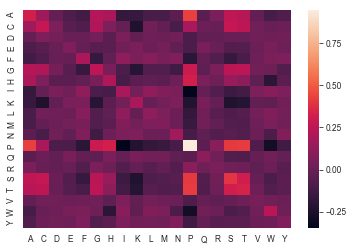

In [113]:
corrDf = df.cov()
sns.heatmap(corrDf)

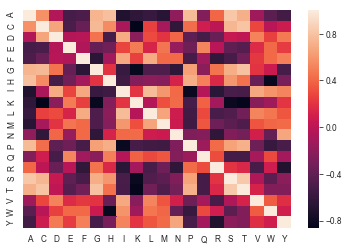

In [171]:
corrDf = df.corr()
sns.heatmap(corrDf)

In [146]:
def E_XY(df0, aa1, aa2):
    if aa1 == aa2:
        df1 = df0[aa1].dropna()
        return df1.dot(df1) / len(df1)
    else:
        df1 = df0[[aa1, aa2]].dropna()
        return df1[aa1].dot(df1[aa2]) / len(df1)

In [147]:
E_XY(df, 'K', 'P')

-0.7134020176447787

In [148]:
df.cov().loc['K', 'P']

-0.22611871818864793

In [149]:
E_XY(df, 'K', 'K')

1.6975871695617353

In [150]:
df.cov().loc['K', 'K']

0.19341964869032585

In [132]:
E_XY(df, 'K', 'T')

-1.7533819712042364

In [133]:
df.cov().loc['K', 'T']

-0.21516234285030675

In [134]:
E_XY(df, 'H', 'A')

0.21540078793823453

In [135]:
df.cov().loc['H', 'A']

0.1962288924746173

In [136]:
aa1 = 'H'
aa2 = 'A'
df1 = df[[aa1, aa2]].dropna()
df1

,H,A
taxon_name,,
Acidobacteria,0.602074,0.203415
Actinobacteria,0.175631,0.151800
Bacteroidetes,0.103473,-0.626877
Chlorobi,0.478441,-0.111823
Chloroflexi,-0.224038,-0.168008
Deferribacteres,-0.315666,-0.521858
Deinococcus-Thermus,-0.309889,0.370394
Dictyoglomi,-0.621175,-0.878299
Firmicutes,0.048607,-0.513315


In [156]:
E_XY_Df = pd.DataFrame({aa2:[E_XY(df, aa1, aa2) for aa1 in aaTable] for aa2 in aaTable}, index=aaTable)
corrDf = E_XY_Df
E_XY_Df

,R,K,H,D,E,S,T,N,Q,C,G,P,A,V,I,L,M,F,W,Y
R,0.649757,0.935351,-0.056550,-0.320724,0.179002,0.152601,-0.948402,0.025737,0.168945,-0.196401,-0.213896,-0.214696,-0.289964,-0.487528,-0.653024,-0.401154,-0.770826,-0.032852,0.047976,-0.500654
K,0.935351,1.697587,-0.144226,-0.507975,0.343938,-0.025726,-1.753382,0.195134,0.266777,-0.565082,-0.664881,-0.713402,-0.695504,-0.776247,-0.860987,-0.524758,-1.127641,0.110961,0.034831,-0.680255
H,-0.056550,-0.144226,0.205436,-0.020721,-0.069318,0.125023,0.220991,0.006179,0.050471,0.039190,0.066074,0.391101,0.215401,-0.000583,-0.030404,-0.014124,0.052099,-0.017985,-0.208349,-0.004786
D,-0.320724,-0.507975,-0.020721,0.184402,-0.070813,-0.038624,0.494449,-0.007409,-0.099040,0.148686,0.164241,0.059811,0.165708,0.256088,0.333533,0.187296,0.368169,-0.014762,0.023004,0.230396
E,0.179002,0.343938,-0.069318,-0.070813,0.125967,-0.037202,-0.370700,0.019520,0.093478,-0.069275,-0.111826,-0.226929,-0.185326,-0.125181,-0.133222,-0.072577,-0.172912,-0.001022,0.078981,-0.099917
S,0.152601,-0.025726,0.125023,-0.038624,-0.037202,0.410915,0.101041,-0.009900,-0.015073,0.235206,0.212497,0.340073,0.156774,-0.083161,-0.285538,-0.227260,-0.248715,-0.145364,-0.091404,-0.140985
T,-0.948402,-1.753382,0.220991,0.494449,-0.370700,0.101041,1.906466,-0.210409,-0.298737,0.588673,0.738601,0.914176,0.803357,0.786720,0.798343,0.471714,1.119271,-0.151270,-0.130208,0.685591
N,0.025737,0.195134,0.006179,-0.007409,0.019520,-0.009900,-0.210409,0.174056,-0.003898,-0.102320,-0.174091,-0.165403,-0.101518,-0.086550,-0.019364,-0.045102,-0.100897,0.069994,-0.071498,-0.004763
Q,0.168945,0.266777,0.050471,-0.099040,0.093478,-0.015073,-0.298737,-0.003898,0.142578,-0.012857,-0.079251,-0.096065,-0.116829,-0.121509,-0.141208,-0.031755,-0.141705,-0.018395,0.037464,-0.108840
C,-0.196401,-0.565082,0.039190,0.148686,-0.069275,0.235206,0.588673,-0.102320,-0.012857,0.329387,0.298732,0.273983,0.222445,0.232874,0.112754,0.075377,0.245404,-0.087654,-0.001018,0.156554


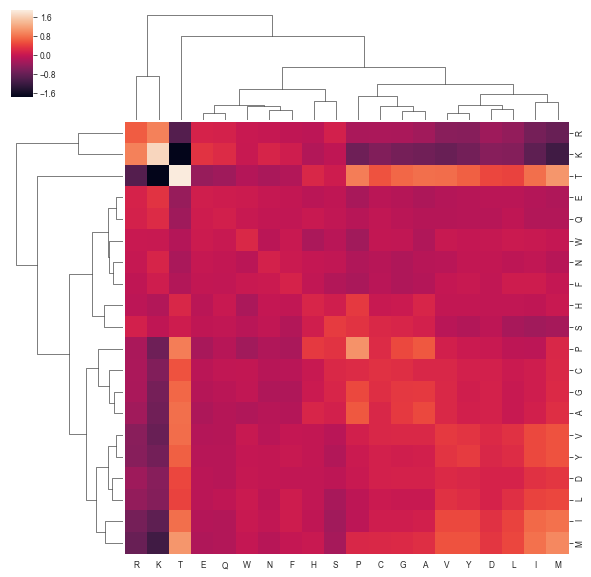

In [157]:
sns.clustermap(corrDf)

In [97]:
from mwTools.plot import get_divergent_color_map
from matplotlib.font_manager import FontProperties

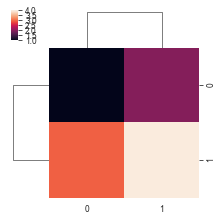

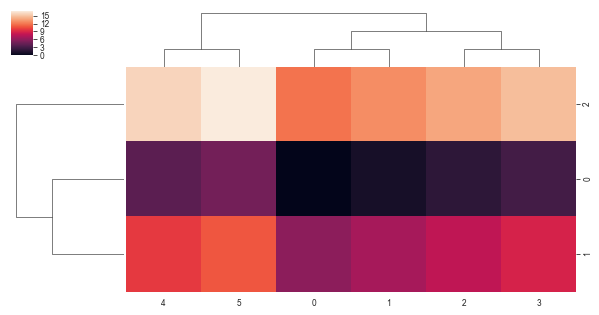

In [53]:
dataFrameA = pd.DataFrame([ [1,2],[3,4] ])
dataFrameB = pd.DataFrame( np.arange(3*6).reshape(3,-1))

def fixedWidthClusterMap(dataFrame, cellSizePixels=50, **kwargs):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom']
    Ny,Nx = dataFrame.shape
    figWidth = (Nx*cellSizePixels/dpi)/0.8/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/0.8/marginHeight

    # do the actual plot
    grid = sns.clustermap(dataFrame, figsize=(figWidth, figHeigh), **kwargs)

    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, 
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_row_orig_pos = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, 
                                         ax_row_orig_pos.width, axHeight])
    ax_col_orig_pos = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    return grid # return ClusterGrid object

grid = fixedWidthClusterMap(dataFrameA, cellSizePixels=75)
plt.show()
grid = fixedWidthClusterMap(dataFrameB, cellSizePixels=75)
plt.show()

/users/lserrano/mweber/Analysis_data/C-terminal/Taxonomic_tree/phyla_composition_bias_aa_Cterminal_correlation_clustermap


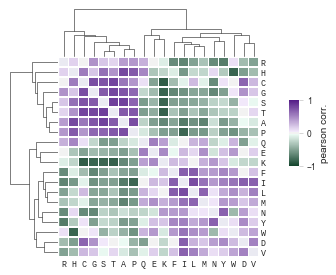

In [173]:
plotData = corrDf.copy()

filename = str(analysisCtermPath / 'Taxonomic_tree' / ("phyla_composition_bias_aa_Cterminal_correlation_clustermap"))
vmax1 = 1

# filename = str(analysisCtermPath / 'Taxonomic_tree' / ("phyla_composition_bias_aa_Cterminal_covariance_clustermap"))

# filename = str(analysisCtermPath / 'Taxonomic_tree' / ("phyla_composition_bias_aa_Cterminal_E_XY_clustermap"))
# vmax1 = 1.7

linewidth1 = 0.5

# We place the colorbar under the main plot, so that the limiting size is the width.
width = 4
aspectratio = 0.6
cmap = get_divergent_color_map(name="RdBu_r")
cmap = sns.diverging_palette(145, 280, s=85, l=25, n=65, as_cmap=True)
colorBackground1 = '0.85'
colorHeatmapLine = 'white'
colorAxis = '0.8'
cbarOrientation = 'horizontal'
figsize = (width, (width/aspectratio))

# fig, (ax,cbar_ax) = plt.subplots(1, 2, figsize=figsize)
# fig, _ = plt.subplots(figsize=figsize)

# main axes
# ax.set_position([0, 0, 1, 1])
# ax.set_facecolor(colorBackground1)

# Create axes for the colorbar for more precise positioning
# cbar_ax.set_position([0.85, 0.45, 0.5/25, 0.5])
# cbar_aspect = 20
# cbar_length = 0.4
# if cbarOrientation == 'horizontal':
#     cbar_ax.set_position([0.05, -0.3, cbar_length, cbar_length/cbar_aspect])

cbarLabel = 'pearson corr.'
# cbarLabel = 'covariance'
# cbarLabel = '<log2(oddsRatio)_aa1 *\nlog2(oddsRatio)_aa2>'
mask = np.diag(len(plotData)*[True])
# mask = False

# g = sns.clustermap(plotData,
g = fixedWidthClusterMap(plotData, cellSizePixels=10,
                         cmap=cmap, mask=mask,
#                   ax=ax,
#                   cbar_ax=cbar_ax,
#                    cbar_kws=dict(label=cbarLabel, orientation=cbarOrientation),
                   cbar_kws=dict(label=cbarLabel),
                   xticklabels=True, yticklabels=True,
                   vmin=-vmax1, vmax=vmax1,
                   linewidth=linewidth1, linecolor=colorHeatmapLine)
ax = g.ax_heatmap
cbar_ax = g.cax

# cbar_ax = fig.axes[-1]
tickLength = FontProperties(size='small').get_size()/2
cbar_ax.yaxis.set_ticks([-vmax1, 0, vmax1])
cbar_ax.tick_params(axis='y', length=tickLength, color=colorAxis)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    # spine.set_color('0.8')
    spine.set_linewidth(0.4)
tickLabelsPad = 2
ax.tick_params(axis='y', pad=tickLabelsPad, length=0)
ax.tick_params(axis='x', pad=tickLabelsPad, length=0)
ax.yaxis.set_tick_params(rotation=0)
family = 'Liberation Mono'
ticks_font = FontProperties(family=family, size='small')
for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
cbar_ax.set_position([1., 0.4, 0.03, 0.2])
    
print(filename)

plt.savefig(filename + ".svg", dpi=400, bbox_inches="tight")
plt.savefig(filename + ".png", dpi=400, bbox_inches="tight")

#### adjust phylotree

Import the phylo tree and prune it to the exact list of phyla that are present in the heatmap plot.

In [615]:
with (phyloDataPath / '{}.txt'.format(phyloTreeName)).open() as f:
    phyloTree5 = Tree(f.read())
phyloTree5

Tree node '' (-0x7ffff8016d91005b)

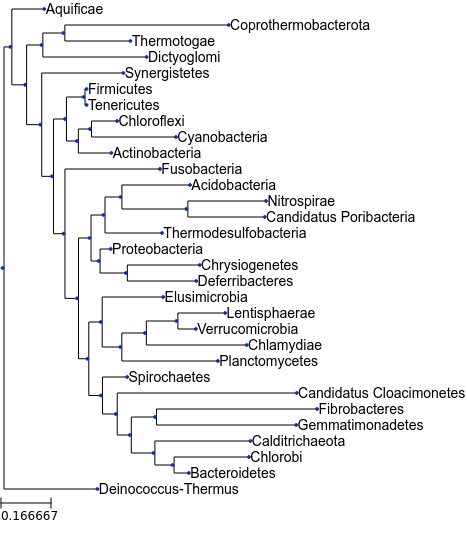

In [616]:
ts = TreeStyle()
ts.scale = 300
ts.show_branch_length = False
ts.show_branch_support = False
phyloTree5.render("%%inline", tree_style=ts)

In [617]:
phyloPhylaList = [n.name for n in phyloTree5.get_leaves()]
len(phyloPhylaList)

31

In [618]:
phyloPhylaList

['Aquificae',
 'Coprothermobacterota',
 'Thermotogae',
 'Dictyoglomi',
 'Synergistetes',
 'Firmicutes',
 'Tenericutes',
 'Chloroflexi',
 'Cyanobacteria',
 'Actinobacteria',
 'Fusobacteria',
 'Acidobacteria',
 'Nitrospirae',
 'Candidatus Poribacteria',
 'Thermodesulfobacteria',
 'Proteobacteria',
 'Chrysiogenetes',
 'Deferribacteres',
 'Elusimicrobia',
 'Lentisphaerae',
 'Verrucomicrobia',
 'Chlamydiae',
 'Planctomycetes',
 'Spirochaetes',
 'Candidatus Cloacimonetes',
 'Fibrobacteres',
 'Gemmatimonadetes',
 'Calditrichaeota',
 'Chlorobi',
 'Bacteroidetes',
 'Deinococcus-Thermus']

In [619]:
plotPhylaSet = set(oddsRatioDf.index.get_level_values('taxon_name').unique()) - {'Cloacimonetes'}

In [620]:
len(plotPhylaSet)

30

In [621]:
plotPhylaSet - set(phyloPhylaList)

{'Armatimonadetes', 'Caldiserica', 'Ignavibacteriae'}

In [622]:
set(phyloPhylaList) - plotPhylaSet

{'Calditrichaeota',
 'Candidatus Poribacteria',
 'Coprothermobacterota',
 'Lentisphaerae'}

Remove the 4 phyla that are in the phyloTree but not in the plot.

In [623]:
len(phyloTree5.get_leaves())

31

In [624]:
for n in phyloTree5.get_leaves():
    if n.name not in plotPhylaSet:
        print(n.name)
        n.delete()

Coprothermobacterota
Candidatus Poribacteria
Lentisphaerae
Calditrichaeota


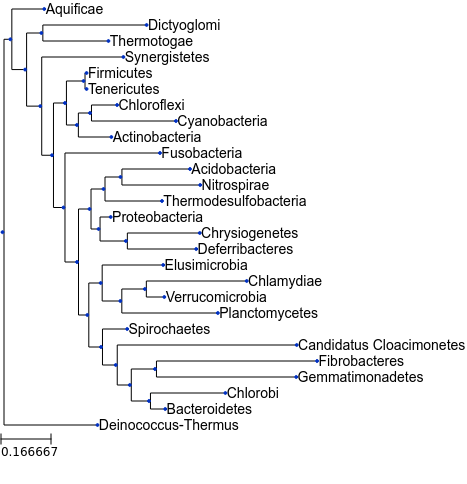

In [625]:
ts = TreeStyle()
ts.scale = 300
ts.show_branch_length = False
ts.show_branch_support = False
phyloTree5.render("%%inline", tree_style=ts)

In [626]:
len(phyloTree5.get_leaves())

27

In [627]:
phyloTree5Filename = str(phyloDataPath / 'phyloTree5.txt')
phyloTree5.write(outfile=phyloTree5Filename, format=0)

In [628]:
from Bio import Phylo

In [650]:
tree = Phylo.read(phyloTree5Filename, 'newick')

The parser cannot understand names with whitespace, so we correct them...

In [651]:
node = [n for n in tree.get_terminals() if n.name == 'Cloacimonetes'][0]
node.name = 'Candidatus Cloacimonetes'

In [652]:
leaves = tree.get_terminals()
leavesXPos = [tree.distance(n) for n in leaves]
nLeaves = len(leaves)
nLeaves

27

In [653]:
leaves

[Clade(branch_length=0.103056, name='Aquificae'),
 Clade(branch_length=0.340813, name='Dictyoglomi'),
 Clade(branch_length=0.213618, name='Thermotogae'),
 Clade(branch_length=0.267231, name='Synergistetes'),
 Clade(branch_length=0.0001, name='Firmicutes'),
 Clade(branch_length=0.0001, name='Tenericutes'),
 Clade(branch_length=0.0803297, name='Chloroflexi'),
 Clade(branch_length=0.276537, name='Cyanobacteria'),
 Clade(branch_length=0.104967, name='Actinobacteria'),
 Clade(branch_length=0.311584, name='Fusobacteria'),
 Clade(branch_length=0.221823, name='Acidobacteria'),
 Clade(branch_length=0.25573, name='Nitrospirae'),
 Clade(branch_length=0.184888, name='Thermodesulfobacteria'),
 Clade(branch_length=0.0304331, name='Proteobacteria'),
 Clade(branch_length=0.236282, name='Chrysiogenetes'),
 Clade(branch_length=0.224399, name='Deferribacteres'),
 Clade(branch_length=0.198368, name='Elusimicrobia'),
 Clade(branch_length=0.329537, name='Chlamydiae'),
 Clade(branch_length=0.0548692, name='V

The Biopython PhyloTree package chooses a different order for the sister leaves sometimes. We re-adjust the order of the phyla.

In [654]:
phyloPhylaPlotList = [n.name for n in leaves]
len(phyloPhylaPlotList)

27

In [655]:
len(set(phyloPhylaPlotList))

27

In [656]:
len(plotPhylaSet)

30

In [657]:
plotPhylaSet - set(phyloPhylaPlotList)

{'Armatimonadetes', 'Caldiserica', 'Ignavibacteriae'}

In [658]:
set(phyloPhylaPlotList) - plotPhylaSet

set()

In [659]:
plotPhylaList = (
    phyloPhylaPlotList +
    list(plotPhylaSet - set(phyloPhylaPlotList)))
print(len(plotPhylaList))
plotPhylaList

30


['Aquificae',
 'Dictyoglomi',
 'Thermotogae',
 'Synergistetes',
 'Firmicutes',
 'Tenericutes',
 'Chloroflexi',
 'Cyanobacteria',
 'Actinobacteria',
 'Fusobacteria',
 'Acidobacteria',
 'Nitrospirae',
 'Thermodesulfobacteria',
 'Proteobacteria',
 'Chrysiogenetes',
 'Deferribacteres',
 'Elusimicrobia',
 'Chlamydiae',
 'Verrucomicrobia',
 'Planctomycetes',
 'Spirochaetes',
 'Candidatus Cloacimonetes',
 'Fibrobacteres',
 'Gemmatimonadetes',
 'Chlorobi',
 'Bacteroidetes',
 'Deinococcus-Thermus',
 'Armatimonadetes',
 'Caldiserica',
 'Ignavibacteriae']

check that the tree leaves correspond to the correct phyla in the heatmap plot rows.

27
28
29


(0.5, 30.5)

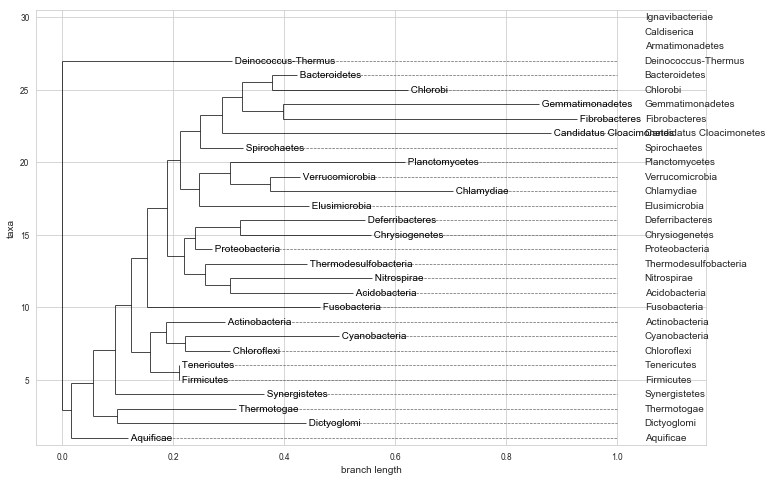

In [687]:
set_fontsize_screen()
fig, ax = plt.subplots(figsize=(12,8))

# Set line width of the tree, based on the default linewidth
lw = 0.7
tree.root.width = lw / plt.rcParams['lines.linewidth']

Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
# Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False, label_func=lambda x: None)
nLeaves = len(leavesXPos)
for i, x in enumerate(leavesXPos):
    y = i + 1
    ax.plot([x + 0.02, 1], [y, y], lw=lw, ls='--', c='0.4')
    ax.annotate(plotData.index[i], xy=(1.05, y), ha='left', va='center')
    
for j in range(nLeaves, len(plotPhylaList)):
    print(j)
    y = j + 1
    ax.annotate(plotData.index[j], xy=(1.05, y), ha='left', va='center')

ax.set_ylim(0.5, len(plotPhylaList) + 0.5)

#### plot

In [352]:
df = oddsRatioDf
df.to_csv(analysisCtermDataPath / 'oddsRatioAATaxon_phyla_-1.csv')

In [665]:
plotData = oddsRatioDf.copy()
plotData = plotData.xs('log2OddsRatio', level='observable')
plotData = plotData[plotData.columns].astype(float)
plotData = plotData[aaTable]
print(len(plotData))
plotData = plotData.loc[plotPhylaList]
print(len(plotData))
plotData.head()

30
30


,R,K,H,D,E,S,T,N,Q,C,G,P,A,V,I,L,M,F,W,Y
taxon_name,,,,,,,,,,,,,,,,,,,,
Aquificae,0.840777,0.348954,-0.115123,-0.246744,-0.098857,0.407429,-0.458028,-0.686117,0.242637,0.524730,0.128379,-0.322060,-0.430740,0.022418,-0.497220,0.132769,-0.938252,0.240269,0.492584,-0.697069
Dictyoglomi,0.714012,1.098500,-0.621175,-0.124576,0.483244,0.264618,-1.166691,-0.346190,0.222286,-0.057088,-0.204196,-1.421499,-0.878299,-0.234424,-0.686029,-0.024851,-1.076251,0.198380,0.688307,-0.287626
Thermotogae,1.119851,0.959589,-0.423305,-0.288394,0.578244,0.013102,-1.226532,-0.495905,0.399099,0.133213,0.089439,-1.100863,-0.706288,-0.382848,-0.476972,-0.280410,-0.582760,0.068778,1.147115,-0.602271
Synergistetes,1.063493,0.934586,-0.080158,0.028260,0.379141,0.228745,-1.649704,0.318864,0.419813,0.045150,-0.113178,-0.551788,-0.329578,-0.620488,-0.425431,-0.183125,-0.957877,-0.217006,0.407689,-0.838880
Firmicutes,0.659274,1.521256,0.048607,-0.108574,0.448993,0.078415,-1.570920,0.351938,0.240035,-0.050824,-0.470714,-1.034591,-0.513315,-0.457571,-0.398575,-0.273429,-0.605886,-0.101746,-0.060811,-0.376882


In [667]:
maskData = oddsRatioDf.xs('BH_multiple_tests', level='observable')
# Mask both rejected cases and null values
maskData = (maskData != True) & (maskData != 'True')
maskData = maskData[aaTable]
print(len(maskData))
maskData = maskData.loc[plotPhylaList]
print(len(maskData))
maskData.head()

30
30


,R,K,H,D,E,S,T,N,Q,C,G,P,A,V,I,L,M,F,W,Y
taxon_name,,,,,,,,,,,,,,,,,,,,
Aquificae,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
Dictyoglomi,False,False,False,True,False,False,False,False,True,True,True,False,False,True,False,True,False,True,False,True
Thermotogae,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False
Synergistetes,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
Firmicutes,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [668]:
from cterminal import colorBackground1, get_line_width, vmax, cmap, colorHeatmapLine
from matplotlib.font_manager import FontProperties
fontSize = 16

In [669]:
taxonNSeqDf = oddsRatioAATaxon[oddsRatioAATaxon['taxon_rank'] == 'phylum'].xs('all', level='stop_codon')\
              .sort_values('taxon_name')\
              [['taxaid', 'taxon_name', 'n_seq', 'n_genomes']]\
              .drop_duplicates().reset_index(drop=True)
taxonNSeqDf = taxonNSeqDf.set_index('taxon_name').loc[plotData.index]
print(len(plotData.index))
print(len(taxonNSeqDf))
print(len(taxonNSeqDf))
taxonNSeqDf = taxonNSeqDf.loc[plotPhylaList]
print(len(taxonNSeqDf))
taxonNSeqDf

30
30
30
30


,taxaid,n_seq,n_genomes
taxon_name,,,
Aquificae,200783,14811,9
Dictyoglomi,68297,3569,2
Thermotogae,200918,35111,18
Synergistetes,508458,7381,4
Firmicutes,1239,756567,259
Tenericutes,544448,45030,54
Chloroflexi,200795,31911,11
Cyanobacteria,1117,226172,62
Actinobacteria,201174,912659,226


In [670]:
oddsRatioDf2 = oddsRatioDf.join(taxonNSeqDf)

threonine is depleted in all phyla.

In [671]:
df = oddsRatioDf2
df = df['T']
(df.loc['log2OddsRatio'].astype(float) < 0) & df.loc['BH_multiple_tests'].replace({'True':True, 'False':False})

taxon_name
Proteobacteria              True
Actinobacteria              True
Firmicutes                  True
Bacteroidetes               True
Cyanobacteria               True
Spirochaetes                True
Deinococcus-Thermus         True
Tenericutes                 True
Thermotogae                 True
Planctomycetes              True
Chloroflexi                 True
Acidobacteria               True
Chlorobi                    True
Verrucomicrobia             True
Chlamydiae                  True
Nitrospirae                 True
Fusobacteria                True
Aquificae                   True
Deferribacteres             True
Synergistetes               True
Ignavibacteriae             True
Thermodesulfobacteria       True
Armatimonadetes             True
Gemmatimonadetes            True
Dictyoglomi                 True
Fibrobacteres               True
Elusimicrobia               True
Chrysiogenetes              True
Candidatus Cloacimonetes    True
Caldiserica                 True

hydrophobic aa

In [231]:
df = oddsRatioDf2
df = df[df['n_seq'] > 3600]
df = df[['V', 'I', 'L', 'M', 'Y']]
df = (df.loc['log2OddsRatio'].astype(float) < 0) & df.loc['BH_multiple_tests'].replace({'True':True, 'False':False})
# df.loc['log2OddsRatio'].astype(float)
print(df.sum().sum())
print(df.values.shape[0] * df.values.shape[1])

115
120


proline biases

In [232]:
df = oddsRatioDf2
# df = df[df['n_seq'] > 3600]
df = df['P']
# df = (df.loc['log2OddsRatio'].astype(float) < 0) & df.loc['BH_multiple_tests'].replace({'True':True, 'False':False})
df.loc['log2OddsRatio'].astype(float)
df.loc['oddsRatio'].loc[['Tenericutes', 'Fusobacteria']].astype(float)

taxon_name
Tenericutes     0.229501
Fusobacteria    0.170561
Name: P, dtype: float64

In [233]:
df = oddsRatioDf2
# df = df[df['n_seq'] > 3600]
df = df['P']
# df = (df.loc['log2OddsRatio'].astype(float) < 0) & df.loc['BH_multiple_tests'].replace({'True':True, 'False':False})
phylaPositive = df.loc['log2OddsRatio'].astype(float).sort_values().iloc[-6:].index
# df.loc['oddsRatio'].loc[['Deinococcus-Thermus', 'Verrucomicrobia', 'Nitrospirae', 'Armatimonadetes']].astype(float)
df.loc['oddsRatio'].loc[phylaPositive]

taxon_name
Nitrospirae            1.4924397034739494
Verrucomicrobia         1.555957283464888
Armatimonadetes        1.5719165348837152
Deinococcus-Thermus    1.5938215785542784
Gemmatimonadetes       2.0032437289703355
Chrysiogenetes         2.2159776459356775
Name: P, dtype: object

In [234]:
df.loc['BH_multiple_tests'].loc[phylaPositive]

taxon_name
Nitrospirae            True
Verrucomicrobia        True
Armatimonadetes        True
Deinococcus-Thermus    True
Gemmatimonadetes       True
Chrysiogenetes         True
Name: P, dtype: object

In [235]:
df = oddsRatioDf2
df.loc['oddsRatio']['n_seq'].loc[phylaPositive]

taxon_name
Nitrospirae            17802
Verrucomicrobia        23246
Armatimonadetes         4576
Deinococcus-Thermus    51606
Gemmatimonadetes        3913
Chrysiogenetes          2549
Name: n_seq, dtype: int64

In [672]:
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt

In [673]:
# mpl.rcParams.update(mpl.rcParamsDefault)

/users/lserrano/mweber/Analysis_data/C-terminal/Taxonomic_tree/phyla_composition_bias_aa_Cterminal.svg
30


/home/mweber/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


30


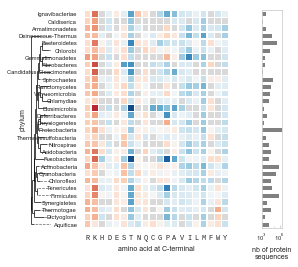

In [688]:
set_fontsize_paper()

def plot_phyla_aa_composition_map(plotData, maskData, terminus, plotTitle):
    
 
    linewidth1 = 0.5
    aspectratio = 1.0
    figsize = (4.5, 4)
    sns.set_style('whitegrid')

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 3, width_ratios=[0.1, 1, 0.1], wspace=0.05)
    
    ax = fig.add_subplot(gs[0, 0])
#     Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False, label_func=lambda x: None)
    nLeaves = len(leavesXPos)
    for i, x in enumerate(leavesXPos):
        y = i + 1
        ax.plot([x + 0.02, 1], [y, y], lw=lw, ls='--', c='0.4')
#         ax.annotate(plotData.index[i], xy=(1.05, y), ha='left', va='center')
    ax.set_ylim(0.5, len(plotPhylaList) + 0.5)
    ax.set_xlim(0, 0.7)
    ax.axis('off')
    ax.annotate('phylum', xy=(0, 0.5), xytext=(-5, 0), xycoords='axes fraction', textcoords='offset points',
                ha='right', va='center', rotation=90)
    
    ax = fig.add_subplot(gs[0, 1])
    ax.set_facecolor(colorBackground1)
    print(len(plotData))
    
    ax = sns.heatmap(plotData[::-1], square=True, mask=maskData[::-1], ax=ax, cmap=cmap,
                         cbar=False, vmin=-vmax, vmax=vmax,
                         xticklabels=True, yticklabels=True,
                         linewidth=linewidth1, linecolor=colorHeatmapLine
                         )
    ax.tick_params(axis='y', labelleft='on', labelright='off')
    for tick in ax.get_yticklabels():
        tick.set_bbox(dict(pad=0, facecolor='none', edgecolor='none'))
    
    family = 'Liberation Mono'
    ticks_font = FontProperties(family=family)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(ticks_font)
        tick.set_bbox(dict(pad=0, facecolor='none', edgecolor='none'))

    ax.set_xlabel('amino acid at ' + terminus + '-terminal')
    ax.set_ylabel('')
    
    ax = fig.add_subplot(gs[0, 2])
    colorNBar = sns.color_palette()[7]
    colorNBar = '0.5'
    print(len(taxonNSeqDf))
    with sns.axes_style('ticks'):
    #     taxonNSeqDf[::-1]['n_seq'].plot.barh(ax=ax, legend=False, color=[colorNBar for _ in range(len(taxonNSeqDf))])
        df = taxonNSeqDf['n_seq']
        ax.barh(range(len(df)), df.values, height=0.7, color=[colorNBar for _ in range(len(taxonNSeqDf))])
        ax.set_ylim(-0.5, len(df) - 0.5)
        ax.set_xlabel('nb of protein\nsequences')
        ax.set_xscale('log')
        ax.set_xlim(1e3, 2.5e6)
#         ax.set_xticks([1e3, 1e4, 1e5, 1e6])
        ax.set_xticks([1e3, 1e6])
        ax.set_xticks([1e4, 1e5], minor = True)
        ax.tick_params(axis='x', bottom=True, color='0.8', direction='in', which='both')
        ax.tick_params(axis='x', which='minor', labelbottom=False)
    #     ax.tick_params(axis='x', reset=True)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel('')
    #     sns.despine(ax=ax)
        ax.grid(False)
    
#     plt.subplots_adjust(wspace=0)
#     fig.tight_layout()
    return fig

filenamePlot = analysisCtermPath / 'Taxonomic_tree' / ("phyla_composition_bias_aa_" + terminus + "terminal" + ".svg")
print(filenamePlot)

plotTitle = 'C-terminal biases by phyla'
fig = plot_phyla_aa_composition_map(plotData, maskData, terminus, plotTitle)
fig.savefig(filenamePlot, dpi=400, bbox_inches="tight")

### Plot aa bias variation across families

#### import odds ratio df

In [736]:
oddsRatioAATaxon.head()

A     C  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  D     E  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all          True  True   
                                                  TAA         False  True   
                                                  TAG         False  True   
                                                  TGA          True  True   
                                                  all          True  True   

                                                                 F     G  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  H     I  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all          True  True   
                                                  TAA         False  True   
                                                  TAG          True  True   
                                                  TGA         False  True   
                                                  all          True  True   

                                                                 K      L  \
terminus position from terminus observable        stop_codon                
C        -20                    BH_multiple_tests all         True   True   
                                                  TAA         True  False   
                                                  TAG         True  False   
                                                  TGA         True   True   
                                                  all         True   True   

                                                                  ...       \
terminus position from terminus observable        stop_codon      ...        
C        -20                    BH_multiple_tests all             ...        
                                                  TAA             ...        
                                                  TAG             ...        
                                                  TGA             ...        
                                                  all             ...        

                                                                 S     T  \
terminus position from terminus observable        stop_codon               
C        -20                    BH_multiple_tests all         True  True   
                                                  TAA         True  True   
                                                  TAG         True  True   
                                                  TGA         True  True   
                                                  all         True  True   

                                                                  V      W  \
terminus position from terminus observable        stop_codon                 
C        -20                    BH_multiple_tests all          True  False   
                                                  TAA          Tr

In [788]:
len(oddsRatioAATaxon[oddsRatioAATaxon['taxon_rank'] == 'family']['taxon_name'].unique())

280

In [737]:
oddsRatioDf = oddsRatioAATaxon
terminus = 'C'
terminusPos = -1

In [738]:
oddsRatioDf = oddsRatioDf[oddsRatioDf['taxon_rank'] == 'family']\
              .xs('all', level='stop_codon')\
              .xs(terminusPos, level='position from terminus')\
              .xs(terminus, level='terminus')
oddsRatioDf = oddsRatioDf.sort_values('n_seq', ascending=False)
oddsRatioDf = oddsRatioDf.drop(['n_genomes', 'n_seq', 'taxaid', 'taxon_rank'], axis=1)\
                         .set_index('taxon_name', append=True)
oddsRatioDf.head()

,,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
observable,taxon_name,,,,,,,,,,,,,,,,,,,,
count,Streptomycetaceae,26689,1627,7563,6567,2834,23691,4294,2421,5430,9184,925,2424,12669,3744,25449,14476,5536,8914,2058,1659
log2OddsRatio,Streptomycetaceae,0.2265277950363352,0.2992563488073531,-0.4518439198366685,-0.5824723633697588,-0.73091202358558,0.6067513925883713,0.115962969641525,-1.1083725708104932,0.6916873181588425,-1.032793282164568,-1.3958790802974022,-0.25383403375478325,0.3252309695704953,-0.29255924454024607,1.0337402246408502,0.8870781559279193,-0.9129024439320848,-0.7340054583011605,-0.3401322849910919,-1.1254208887368486
oddsRatio,Streptomycetaceae,1.170015623861049,1.2305099715097516,0.7311078159357289,0.6678183480896092,0.6025228985871801,1.5228263013392762,1.083698150677898,0.46381694370890403,1.6151714538444615,0.48876291101444724,0.3800130636179067,0.8386646580646107,1.2528650011272644,0.816452441135263,2.0473251210672743,1.8494267435462795,0.5311155064428897,0.6012323497386702,0.7899688739512456,0.45836827872221075
pvalue,Streptomycetaceae,9.280289017859737e-118,8.719457435037958e-16,4.53260508595443e-171,5.265241330711825e-255,1.7170966463516603e-185,0.0,2.8674912829845837e-07,0.0,2.4339649010841123e-228,0.0,3.095473544447308e-265,1.1147740460754735e-18,3.992096128083364e-123,1.164997228108369e-36,0.0,0.0,0.0,0.0,3.1866840242795416e-28,7.660499522887227e-286
BH_multiple_tests,Streptomycetaceae,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


#### plot

In [739]:
df = oddsRatioDf
df.to_csv(analysisCtermDataPath / 'oddsRatioAATaxon_family_-1.csv')

In [740]:
plotData = oddsRatioDf.copy()
plotData = plotData.xs('log2OddsRatio', level='observable')
plotData = plotData[plotData.columns].astype(float)
plotData = plotData[aaTable]
print(len(plotData))
plotData.head()

280


,R,K,H,D,E,S,T,N,Q,C,G,P,A,V,I,L,M,F,W,Y
taxon_name,,,,,,,,,,,,,,,,,,,,
Streptomycetaceae,1.033740,0.691687,0.115963,-0.451844,-0.582472,0.887078,-0.912902,-0.253834,-0.292559,0.299256,0.606751,0.325231,0.226528,-0.734005,-1.108373,-1.032793,-1.395879,-0.730912,-0.340132,-1.125421
Bacillaceae,0.694519,1.503824,-0.009416,-0.331843,0.380121,0.532131,-1.309116,0.288984,0.414670,0.111135,-0.539582,-1.110580,-0.447931,-0.446670,-0.659414,-0.327740,-0.446976,-0.199246,-0.325799,-0.441376
Pseudomonadaceae,0.808365,0.638225,0.779803,-0.027491,-0.121702,0.141272,-1.131024,-0.004150,0.076461,-0.092514,0.055758,0.438478,0.342287,-0.504859,-0.742899,-0.503054,-1.619995,0.032542,-0.540031,-0.799712
Flavobacteriaceae,0.328099,1.496206,0.056329,-0.233727,0.269650,-0.197314,-1.989271,0.678033,0.298088,-0.314190,-1.198933,-0.967539,-0.696949,-0.666094,-0.412028,0.135452,-0.749616,0.442650,-0.357783,-0.328588
Mycobacteriaceae,1.274035,0.724049,0.161942,-0.443030,-0.490876,0.865559,-0.517547,-0.027426,0.298020,0.206073,0.494381,0.217766,-0.113467,-0.804514,-1.143616,-0.786174,-1.534657,-0.591762,-0.255567,-0.924715


Instead of filtering the significant biases, we consider them ALL. Thus, we want to take into account that a small species/family that has no bias and bad pvalue should also appear on the plot, to have an idea of the true *distribution* of the biases across the families. ideally for this species we should have a bias 0. in practice, it will probably be a noisy value around 0.

/users/lserrano/mweber/Analysis_data/C-terminal/Taxonomic_tree/family_composition_bias_aa_Cterminal.svg


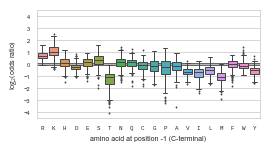

In [785]:
set_fontsize_paper()

linewidth1 = 0.5
aspectratio = 1.0
figsize = (4, 2)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=figsize)

ymin, ymax = -4.5, 4.5
ax.set_ylim(ymin, ymax)
ax.set_yticks(list(range(-4,5)))

ax.axhline(0, color='0.4', lw=3, zorder=0)
sns.boxplot(ax=ax, data=plotData, fliersize=1, linewidth=1)
# plt.setp(ax.lines, zorder=100)
# plt.setp(ax.collections, zorder=100)
# plt.setp(ax.artists, zorder=100)

ylabel = '$\log_2$(odds ratio)'
ax.set_ylabel(ylabel)
ax.xaxis.grid(False)
family = 'Liberation Mono'
ticks_font = FontProperties(family=family, size='small')
for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
    tick.set_bbox(dict(pad=0, facecolor='none', edgecolor='none'))
ax.set_xlabel('amino acid at position -1 (C-terminal)')

plotTitle = 'C-terminal biases for all families'
filenamePlot = analysisCtermPath / 'Taxonomic_tree' / ("family_composition_bias_aa_" + terminus + "terminal" + ".svg")
print(filenamePlot)
fig.savefig(filenamePlot, dpi=400, bbox_inches="tight")

### Anti-correlation K-T

In [728]:
df = oddsRatioDf2
# df = df[df['n_seq'] > 3600]
# df = df[['V', 'I', 'L', 'M', 'Y']]
mask = df.loc['BH_multiple_tests'].replace({'True':True, 'False':False}).drop(['taxaid', 'n_seq', 'n_genomes'], axis=1)
df = df.loc['log2OddsRatio'].astype(float)
df = df.where(mask, other=np.nan)
df

,A,C,D,E,F,G,H,I,K,L,...,Q,R,S,T,V,W,Y,taxaid,n_seq,n_genomes
taxon_name,,,,,,,,,,,,,,,,,,,,,
Proteobacteria,0.288529,-0.153946,-0.201161,0.133270,0.071782,0.022155,0.491855,-0.716098,1.068777,-0.569178,...,0.187239,0.701727,0.260771,-1.113000,-0.653482,-0.306646,-0.511856,NaN,NaN,NaN
Actinobacteria,0.151800,0.163020,-0.363803,-0.360211,-0.617223,0.411100,0.175631,-1.128913,0.889206,-0.839082,...,0.021426,1.205441,0.878221,-0.950845,-0.915173,-0.270426,-0.932233,NaN,NaN,NaN
Firmicutes,-0.513315,-0.050824,-0.108574,0.448993,-0.101746,-0.470714,0.048607,-0.398575,1.521256,-0.273429,...,0.240035,0.659274,0.078415,-1.570920,-0.457571,-0.060811,-0.376882,NaN,NaN,NaN
Bacteroidetes,-0.626877,-0.386999,-0.333398,0.403543,0.482358,-1.034605,0.103473,-0.417397,1.608213,0.042475,...,0.312528,0.516882,-0.230341,-2.031291,-0.685283,-0.099231,-0.290432,NaN,NaN,NaN
Cyanobacteria,-0.217738,0.222348,-0.058681,-0.165414,0.294586,-0.138919,NaN,-0.551320,0.793348,-0.546653,...,-0.250737,0.478320,0.892948,-0.771388,-0.336598,-0.240082,-0.156700,NaN,NaN,NaN
Spirochaetes,-0.503817,-0.519045,-0.357479,0.389756,0.187683,-0.476747,-0.231203,-0.515426,1.210990,-0.097983,...,0.391288,0.695120,-0.144621,-0.971068,-0.274169,0.217535,-0.360297,NaN,NaN,NaN
Deinococcus-Thermus,0.370394,-0.470443,NaN,-0.123055,-0.491155,0.237676,-0.309889,-1.410313,0.963830,-0.760723,...,-0.180437,0.930780,0.376080,-0.991308,-0.717798,NaN,-1.020731,NaN,NaN,NaN
Tenericutes,-0.830480,-0.454688,-0.283151,0.313731,-0.196502,-0.790958,-0.460464,-0.288322,1.663795,-0.600515,...,-0.217037,0.415596,-0.156728,-1.559080,-0.512005,0.432698,-0.159232,NaN,NaN,NaN
Thermotogae,-0.706288,NaN,-0.288394,0.578244,NaN,0.089439,-0.423305,-0.476972,0.959589,-0.280410,...,0.399099,1.119851,NaN,-1.226532,-0.382848,1.147115,-0.602271,NaN,NaN,NaN


In [734]:
len(df[['K', 'T']])

30

In [733]:
df[['K', 'T']].corr()

,K,T
K,1.000000,-0.843104
T,-0.843104,1.000000


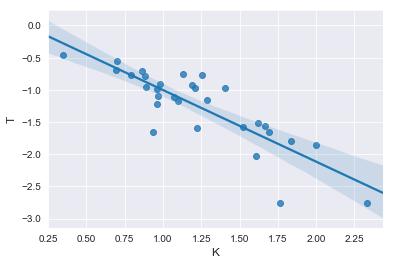

In [732]:
sns.regplot(data=df[['K', 'T']], x='K', y='T')

### Plot biases on tree

In [150]:
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, TextFace

Check that all taxa nodes in the taxonomic tree are present in the c-terminal bias result dataframe. Yes. However we have 178 taxaid in the tree that are NOT in the bias results from RefSeq. We will just not draw any bias for these but still keep them in the tree.

In [154]:
print(len(set(refSeqTreeTaxIdList)))
print(len(set(oddsRatioCtermTaxon['taxaid'])))
print(len(set(oddsRatioCtermTaxon['taxaid']) & set(refSeqTreeTaxIdList)))
print(len(set(oddsRatioCtermTaxon['taxaid']) - set(refSeqTreeTaxIdList)))
print(len(set(refSeqTreeTaxIdList) - set(oddsRatioCtermTaxon['taxaid'])))

4083
2859
2859
0
1224


Add a weight to each node proportional to the nb of protein sequences in the taxon. We will also **cut the branches for which we do not have any bias statistics**.

In [155]:
oddsRatioCtermTaxon.columns

Index(['position from terminus', 'observable', 'terminus', 'R', 'H', 'K', 'D',
       'E', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'A', 'I', 'L', 'M', 'F', 'W',
       'Y', 'V', 'taxaid', 'taxon_name', 'taxon_rank', 'n_seq', 'n_genomes'],
      dtype='object')

If we just delete all the nodes that are not in the taxid list, we will loose some parents and the tree is then reduced to ~36 nodes. I don't know exactly why, because the delete method should assign the parent node to the children node, such that no connection is lost.

In [236]:
i = 0
for node in refSeqTree.traverse():
    i += 1
i

677

In [237]:
matches = []
for node in refSeqTree.traverse():
    if int(node.name) not in set(oddsRatioCtermTaxon['taxaid']) and node.rank in ['species', 'subspecies', 'genus']:
        matches.append(node)
len(matches)

92

In [238]:
for node in matches:
    node.delete()

In [239]:
matches = []
for node in refSeqTree.traverse():
    if int(node.name) not in set(oddsRatioCtermTaxon['taxaid']) and node.rank in ['no rank']:
        matches.append(node)
len(matches)

47

In [240]:
for node in matches:
    node.delete()

In [157]:
i = 0
for node in refSeqTree.traverse():
    i += 1
i

4083

In [158]:
verbose = 1
biasTaxaidList = set(oddsRatioCtermTaxon['taxaid'])

for node in refSeqTree.traverse():
    taxaId = int(node.name)
    if taxaId in biasTaxaidList:
        if verbose >= 2: print("taxaId", taxaId)
        ctermDf = oddsRatioCtermTaxon[(oddsRatioCtermTaxon['taxaid'] == taxaId)]
        
        nGenomes = ctermDf['n_genomes'].iloc[0]
        if verbose >= 2: print("nGenomes", nGenomes)
        node.add_feature('n_genomes', nGenomes)

        nSeq = ctermDf['n_seq'].iloc[0]
        if verbose >= 2: print("nSeq", nSeq)
        node.add_feature('n_seq', nSeq)

        ctermAADict = {}
        for ctermAA in aaTable:
            log2OddsRatio = ctermDf[(ctermDf['observable'] == 'log2OddsRatio')][ctermAA].iloc[0]
            pvalue = ctermDf[(ctermDf['observable'] == 'pvalue')][ctermAA].iloc[0]
            if verbose >= 2: print(ctermAA, log2OddsRatio, pvalue)
            ctermAADict[ctermAA] = {'log2OddsRatio':log2OddsRatio, 'pvalue':pvalue}
        node.add_feature('ctermAADict', ctermAADict)

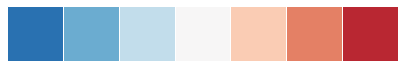

In [159]:
seaborn.palplot(seaborn.color_palette("RdBu_r", 7))

In [160]:
import colorsys

In [161]:
colorMapRGB = seaborn.color_palette("RdBu_r", 31)
colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')

In [162]:
from webcolors import rgb_to_hex

def convert_rgb_to_hex(colormap, x):
    return rgb_to_hex([int(255*i) for i in colormap(x)[:3]])

convert_rgb_to_hex(colormap, 0.2)

'#529cc8'

In [163]:
# example
node = (refSeqTree & '135613')
print(node.n_genomes)
print(node.n_seq)
print(node.ctermAADict)

18
51839.0
{'K': {'log2OddsRatio': 0.55339599319799992, 'pvalue': 9.6037391101599965e-53}, 'Y': {'log2OddsRatio': -0.72363902610999997, 'pvalue': 8.7936622038899969e-51}, 'A': {'log2OddsRatio': 0.150688671637, 'pvalue': 1.0909667309e-14}, 'H': {'log2OddsRatio': 0.41058069707400002, 'pvalue': 1.74276605366e-27}, 'P': {'log2OddsRatio': 0.45108768521499998, 'pvalue': 1.7308128112099989e-67}, 'I': {'log2OddsRatio': -1.1034315169700002, 'pvalue': 6.7237504918799944e-194}, 'L': {'log2OddsRatio': -0.83510588943100006, 'pvalue': 3.5472680474099944e-279}, 'C': {'log2OddsRatio': -0.12947660946799999, 'pvalue': 0.064769176632700001}, 'F': {'log2OddsRatio': -0.117279398587, 'pvalue': 0.0009982161435879999}, 'M': {'log2OddsRatio': -1.4283658071399998, 'pvalue': 1.2718566460999991e-115}, 'R': {'log2OddsRatio': 0.65655524777899998, 'pvalue': 5.8597825971299948e-218}, 'W': {'log2OddsRatio': -0.252877122733, 'pvalue': 7.9022990853699989e-06}, 'V': {'log2OddsRatio': -0.79244439344899997, 'pvalue': 1.055

In [164]:
node.get_ancestors()

[PhyloTree node '1236' (-0x7ffff804bd9210a1),
 PhyloTree node '1224' (-0x7ffff804bd9201af),
 PhyloTree node '2' (-0x7ffff804bd91f11c),
 PhyloTree node '131567' (-0x7ffff804bd91f123)]

The full tree with 4083 nodes is quite difficult to visualize. Thus, we will produce two versions: one full version with the 4083 nodes, and one cut down version that will be more suited for visualization.

We should choose to eliminate those nodes that contain few genomes. However, we still want to keep some nodes with only 1 genome if those represent outgroups in the taxonomic tree. We could delete nodes with only 1 genome. This is very strong and the problem is we leave out some outgroup species that gives a better coverage of the taxonomic tree.

We could also cut down the tree at the family level, except that we keep those nodes that do not have any family node with bias in their ancestors.

In [169]:
refSeqTree2 = refSeqTree.copy("deepcopy")

In [278]:
refSeqTree = refSeqTree2.copy("deepcopy")

In [184]:
treeVersion = 'fullsize'

In [279]:
treeVersion = 'cutdown'

Only keep family nodes. Cut down to the level of family.

In [280]:
familyNodeList = refSeqTree.search_nodes(rank='family')
print(len(familyNodeList))

for famileNode in familyNodeList:
    if 'n_genomes' in famileNode.features:
        if famileNode.n_genomes >= 1:
            for node in famileNode.get_children():
                node.detach()

280


In [285]:
# Test how many nodes are family-orphans
familyOrphansList = []
i = 0
print(len(refSeqTree.get_leaves()))
for node in refSeqTree.get_leaves():
    i += 1
    print([node1.rank for node1 in node.get_ancestors()], node.rank, node.sci_name)
    hasFamilyAncestor = any([node1.rank == 'family' for node1 in node.get_ancestors()] + [node.rank == 'family'])
    if not hasFamilyAncestor:
        familyOrphansList.append(node)
len(familyOrphansList)

335
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Parachlamydiaceae
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Simkaniaceae
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Chlamydiaceae
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Waddliaceae
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Opitutaceae
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Puniceicoccaceae
['genus', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] species Candidatus Xiphinematobacter sp. Idaho Grape
['order', 'class', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Akkermansiaceae
['no rank', 'no rank', 'phylum', 'no rank', 'superkingdom', 'no rank'] species Verrucomicrobia bacterium IMCC26134
['order', 'no rank', 'phylum', 'no rank', 'superkingdom', 'no rank'] family Methylacidiphilaceae
['order', 'class', 'phylum', 'no rank', 'sup

['genus', 'no rank', 'order', 'class', 'phylum', 'superkingdom', 'no rank'] species Methyloceanibacter caenitepidi
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Methylobacteriaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Rhizobiaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Beijerinckiaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Bradyrhizobiaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Xanthobacteraceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Bartonellaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Phyllobacteriaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Hyphomicrobiaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Rhodobiaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Methylocystaceae
['order', 'class', 'phylum', 'superkingdom', 'no rank'] family Brucellaceae
['order', '

55

In [209]:
i = 0
for node in refSeqTree.traverse():
    i += 1
i

674

In [218]:
from ete3.treeview.faces import QColor, QBrush, QPen

class BorderCircleFace(CircleFace):
    def __init__(self, radius, color, style="circle", label=None, borderWidth=1, borderColor='black'):
        super().__init__(radius, color, style, label)
        self._borderWidth = borderWidth
        self._borderColor = borderColor
        
    def update_items(self):
        CircleFace.update_items(self)
        # Set circle border color
        pen = QPen()
        pen.setWidth(self._borderWidth)
        pen.setColor(QColor(self._borderColor))
        self.item.setPen(pen)

# Test
col = QColor.fromHsv(0, 0, 80)
print(col)

t = Tree("(node1, node2);")
for n in t:
    cf = BorderCircleFace(10, "white", borderWidth=3.0, borderColor=col)
    n.add_face(cf, column=10, position="branch-right")
t.render(str(analysisCtermPath / 'Taxonomic_tree' / 'test_BorderCircleFace.png'), dpi=600, w=500);

In [224]:
convert_rgb_to_hex(colormap, 0.5)

'#f7f5f5'

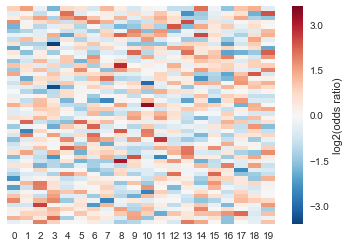

In [238]:
# f, (ax, cbar_ax) = plt.subplots(2)
data = np.random.randn(50, 20)
seaborn.heatmap(data, yticklabels=False, cmap=colormap, cbar_kws={'label':'log2(odds ratio)'})

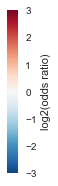

In [274]:
fig, ax = plt.subplots(1, figsize=(0.2, 3))
# ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=3)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=colormap, norm=norm, orientation='vertical')
cb1.set_label('log2(odds ratio)')
plt.savefig(str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_colorbar.svg"), dpi=300)

In [246]:
for showLeafNames in [True, False]:
# for showLeafNames in [False]:
    treeLayout = 'circular'
    treeWidth = 200
    circleNseqThreshList = [3e4, 2e5, 6e5]
    diskBorderColor = QColor.fromHsv(0, 0, 0)
    if showLeafNames:
        circleRadiusList = [1.6*x for x in [28, 45, 100, 160]]
        nodeFontSize = 1.4*24
        diskPosition = 'branch-right'
        labelPosition = "branch-top"
        branchScale = 800
        lineWidth = 4
        diskBorderWidth = 4.0
        if treeVersion == 'fullsize':
            dpi = 2600
        else:
            dpi = 1200
    else:
        circleRadiusList = [1.0*x for x in [28, 40, 80, 160]]
        nodeFontSize = 1*24
        diskPosition = 'branch-right'
        labelPosition = "branch-top"
        branchScale = 300
        lineWidth = 3
        diskBorderWidth = 3
        if treeVersion == 'fullsize':
            dpi = 1400
        else:
            dpi = 1200

    style = NodeStyle()
    style["vt_line_width"] = lineWidth
    style["hz_line_width"] = lineWidth
    for node in refSeqTree.traverse():
        node.set_style(style)

    ctermAAList = aaTable
#     ctermAAList = ['K']

    radiusList = []
    for ctermAA in ctermAAList:

        def layout(node):

            taxid = node.name
            taxonName = node.sci_name  
            if showLeafNames:
                face1 = AttrFace("sci_name", fsize=nodeFontSize, fgcolor="black")
                faces.add_face_to_node(face1, node, 0, position=labelPosition)

            if "n_seq" in node.features:

                pvalue = node.ctermAADict[ctermAA]['pvalue']
                if pvalue < 1e-3:
                    # Creates a sphere face whose size is proportional to nb of sequences
                    radius = log10(node.n_seq)*12.4
                    radius = piecewise(node.n_seq, circleNseqThreshList, circleRadiusList)
                    radiusList.append(radius)
            #         radius = node.n_genomes
                    vmin = -3
                    vmax = -vmin
                    # colormap value has to be in [0, 1]
                    x = (node.ctermAADict[ctermAA]['log2OddsRatio'] - vmin)/(vmax - vmin)
                    color = convert_rgb_to_hex(colormap, x)
                    biasDisk = CircleFace(radius=radius, color=color, style="circle")
                    biasDisk = BorderCircleFace(radius=radius, color=color, style="circle",
                                                borderWidth=diskBorderWidth, borderColor=diskBorderColor)
                    # Let's make the sphere transparent
                    biasDisk.opacity = 0.9
                    # And place as a float face over the tree
                    faces.add_face_to_node(biasDisk, node, 0, position=diskPosition)

        ts = TreeStyle()
#         ts.title.add_face(TextFace("Bias for C-terminal {}".format(ctermAA), fsize=80), column=0)
        ts.show_leaf_name = False

        if treeLayout == 'circular':
            ts.mode = "c"
        elif treeLayout == 'horizontal':
            ts.mode = 'r'
        ts.scale =  branchScale
        # Set our custom layout function
        ts.layout_fn = layout
        filename = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_refSeq_{}_cterm_{}_{}_showLeafNames_{}.svg"\
                       .format(treeLayout, ctermAA, treeVersion, showLeafNames))
        refSeqTree.render(filename, w=treeWidth, units="mm", dpi=dpi, tree_style=ts)

Combine taxonomic tree in single figure

In [277]:
from svgutils.compose import Figure, Panel, Text, SVG, Grid
import svgutils.transform as sg
import sys 

#create new SVG figure
fig = sg.SVGFigure("20cm", "10cm")

# load matpotlib-generated figures
treeLayout = 'circular'
treeVersion = 'cutdown'
showLeafNames = False
filenameK = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_refSeq_{}_cterm_{}_{}_showLeafNames_{}.svg"\
               .format(treeLayout, 'K', treeVersion, showLeafNames))
filenameT = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_refSeq_{}_cterm_{}_{}_showLeafNames_{}.svg"\
               .format(treeLayout, 'T', treeVersion, showLeafNames))
filenameP = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_refSeq_{}_cterm_{}_{}_showLeafNames_{}.svg"\
               .format(treeLayout, 'P', treeVersion, showLeafNames))
filenameL = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_refSeq_{}_cterm_{}_{}_showLeafNames_{}.svg"\
               .format(treeLayout, 'L', treeVersion, showLeafNames))
filenameLegend = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_legend.svg")
filenameColorbar = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_colorbar.svg")
filename = str(analysisCtermPath / 'Taxonomic_tree' / "taxonomic_tree_combined.svg")

# get the plot objects
s1 = 0.05
pos1x, pos1y = 240, 480
font1, size1 = "Arial", 16
Figure(1200, 1000,
       Panel(SVG(filenameK).scale(s1),
             Text("C-terminal K", pos1x, pos1y, anchor='middle', font=font1, size=size1)
            ).move(0, 0),
       Panel(SVG(filenameT).scale(s1),
             Text("C-terminal T", pos1x, pos1y, anchor='middle', font=font1, size=size1)
            ).move(500, 0),
       Panel(SVG(filenameP).scale(s1),
             Text("C-terminal P", pos1x, pos1y, anchor='middle', font=font1, size=size1)
            ).move(0, 500),
       Panel(SVG(filenameL).scale(s1),
             Text("C-terminal L", pos1x, pos1y, anchor='middle', font=font1, size=size1)
            ).move(500, 500),
       Panel(SVG(filenameLegend).scale(s1),
             SVG(filenameColorbar).scale(1.0).move(0, 100),
            ).move(1000, 50)
#        ,Grid(100, 100)
        ).save(filename)